In [1]:
import pandas as pd
import numpy as np

import math
import os

# # Make TensorFlow logs less verbose
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import flwr as fl
import tensorflow_probability as tfp

import keras
from sklearn.model_selection import train_test_split
from utils import model as mod
from flwr.common import NDArrays, Scalar
from scipy.stats import pearsonr
from typing import Dict, Optional, Tuple, List, Union
import typing
import random
import json
np.random.seed(2048)
tf.random.set_seed(2048)
random.seed(2048)
tf.keras.utils.set_random_seed(2048)
NUM_EPOCHS=10
BATCH_SIZE=16
path='resultsbn'
strat='FedProx_Aug'

2023-09-27 15:46:05.501426: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 15:46:05.505830: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 15:46:05.587959: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 15:46:05.590488: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 15:46:07.742109: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
!pwd

/rds/user/sc2427/hpc-work/Final/FL


In [3]:
data=pd.read_csv("all_data.csv")

In [4]:
df = pd.DataFrame(columns = data.columns)


In [5]:

dfs_to_concat = []

for i in range(250, 1000):
    mean_data = data.loc[data['Stamp'] == i].mean()
    dfs_to_concat.append(mean_data)

result_df = pd.concat(dfs_to_concat, axis=1).T.reset_index(drop=True)

In [6]:
df=result_df

In [7]:
def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    for i in range(29):
      x[i]=x[i]+noise[i]
    return x

In [8]:
data_new = pd.DataFrame(columns = data.columns)
for i in range(df.shape[0]):
  data_new=pd.concat([data_new,df.loc[i].to_frame().T])
  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])
  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])

  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])
  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])

  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])
  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])
  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])

  data_new=pd.concat([data_new,gaussian_noise(df.iloc[i], 0, 0.01).to_frame().T])




In [9]:
data_new.shape

(6750, 38)

In [10]:
y_labels=df.columns[-8:]

In [11]:
x_labels=df.columns[1:-8]

In [12]:
x=np.array(data_new[x_labels])

In [13]:
y=np.array(data_new[y_labels])

In [14]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1)

In [15]:
x_train.shape

(5062, 29)

In [16]:
# y_train=y_train.reshape((1,y_train.shape[0],y_train.shape[1]))
y_train.shape

(5062, 8)

In [17]:

model_eval = mod()
model_eval.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError() ])

2023-09-27 15:46:25.581073: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [18]:
def pcc(y_val, y_pred):
  temp={}
  for i in range(len(y_labels)):
    temp[y_labels[i]]=(pearsonr(y_val[:,i],y_pred[:,i])[0])
  return sum(list(temp.values()))/len(list(temp.values()))

In [19]:
class FlowerClient(fl.client.NumPyClient):

    def __init__(self, model,cid, x_train, y_train, x_val, y_val, path) -> None:
        self.model = model
        self.cid=cid
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val
        self.path=path

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=2)
        # loss, rmse = model.evaluate(self.x_val, self.y_val)
        loss,rmse=self.model.evaluate(self.x_val, self.y_val)

        # result["pr"].append(pr)


        try:
          data=pd.read_csv(f"{self.path}/result_{self.cid}.csv")
          data.drop(["Unnamed: 0"], axis=1, inplace=True)

        except:
          data=pd.DataFrame(columns=["round","Loss", "RMSE"])

        data=pd.concat([data,pd.Series([config['server_round'], loss, rmse ] , index=data.columns ).to_frame().T])
        data.to_csv(f"{self.path}/result_{self.cid}.csv")

        return loss, len(self.x_val), {"accuracy": rmse}


In [20]:

#import pearsonr
def get_eval_fn(model, result,result_train):
    """Return an evaluation function for server-side evaluation."""

    # Load data and model here to avoid the overhead of doing it in `evaluate` itself


    # The `evaluate` function will be called after every round
    def evaluate(server_round: int, weights: fl.common.NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        model.set_weights(weights)  # Update model with the latest parameters
        loss, rmse = model.evaluate(x_test, y_test)
        loss_train,rmse_train=model.evaluate(x_train, y_train)
        result_train['Losses'].append(loss_train)
        result_train['rmse'].append(rmse_train)

        result["Losses"].append(loss)
        result["rmse"].append(rmse)
        # result["pr"].append(pr)
        for i in range(len(y_labels)):
          result["pearson"][y_labels[i]].append(pearsonr(y_test[:,i],model.predict(x_test)[:,i])[0])
          result_train['pearson'][y_labels[i]].append(pearsonr(y_train[:,i],model.predict(x_train)[:,i])[0])


        return loss, {"accuracy": rmse}

    return evaluate

In [21]:
model_eval.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 batch_normalization (Batch  (None, 16)                64        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 1016 (3.97 KB)
Trainable params: 952 (3.72

In [22]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

def evaluate_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

In [23]:
ray_init_args = {
            "num_gpus": 0,
            "num_cpus": 3
        }
client_res={"num_gpus": 0, "num_cpus": 3}

In [24]:
inital=mod()
#for clients from 2 to 10, run the strategy for 10 rounds each and create a list of results
results=[]
results_train=[]
# for i in range(5):
for i in range(2,11):
    try:
        os.mkdir(f"{path}/{i}")
    except:
        print()
    try:
        os.mkdir(f"{path}/{i}/{strat}")
    except:
        print()
    
    NUM_CLIENTS = i
    # losses=[]
    def client_fn(cid: str) -> fl.client.Client:
        # Create model
        model = mod()
        model.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError()])    
        partition_size = math.floor(len(x_train) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_train_cid = x_train[idx_from:idx_to]
        full_y_train_cid = y_train[idx_from:idx_to]
    
    
        partition_size = math.floor(len(x_test) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_test_cid = x_test[idx_from:idx_to]
        full_y_test_cid = y_test[idx_from:idx_to]
    
        # Create and return client
        return FlowerClient(model,cid, full_x_train_cid, full_y_train_cid, full_x_test_cid, full_y_test_cid, f"{path}/{i}/{strat}")


    
    
    result={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    result_train={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    try:
        del strategy
    except:
        print('starting')
    # Create FedAvg strategy
    strategy = fl.server.strategy.FedProx(
      min_fit_clients=i,  # Never sample less than 10 clients for training
      evaluate_fn=get_eval_fn(model_eval, result,result_train),
      on_fit_config_fn=fit_config,
      on_evaluate_config_fn=evaluate_config,
      initial_parameters=fl.common.ndarrays_to_parameters(inital.get_weights()),
      proximal_mu=2
    )
    
    # Start simulation
    fl.simulation.start_simulation(
      client_fn=client_fn,
      num_clients=NUM_CLIENTS,
      config=fl.server.ServerConfig(num_rounds=10),
      strategy=strategy,
      ray_init_args=ray_init_args,
      client_resources=client_res,
    )
    results.append(result)
    results_train.append(result_train)
    # print(result)
    # try:
    #     data=pd.read_csv(f"{path}/combine_random{result['clients']}.csv")
    #     data.drop(["Unnamed: 0"], axis=1, inplace=True)
        
    # except:
    #     data=pd.DataFrame(columns=["Method", "Loss_Task1", "RMSE_Task1"])
    # data=pd.concat([data,pd.Series(["FedAvgEWC_Aug", result['Losses'][-1],result['rmse'][-1]] , index=data.columns ).to_frame().T])
    # data.to_csv(f"{path}/combine_random{result['clients']}.csv")



INFO flwr 2023-09-27 15:46:25,982 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)



starting


2023-09-27 15:46:29,862	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:46:30,038	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8268 
INFO flwr 2023-09-27 15:46:31,471 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.43': 1.0,

159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:46:35,734 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 15:46:35,735 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:46:35,736 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)
(pid=237518) 2023-09-27 15:46:36.510856: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=237518) 2023-09-27 15:46:36.513180: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=237518) 2023-09-27 15:46:36.572187: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=237518) 2023-09-27 15:46:36.572736: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=237518) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 1.6590 - root_mean_squared_error: 1.2880
(launch_and_fit pid=237518) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2422 - root_mean_squared_error: 0.4921
(launch_and_fit pid=237518) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2401 - root_mean_squared_error: 0.4900
(launch_and_fit pid=237518) Epoch 4/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2362 - root_mean_squared_error: 0.4860
(launch_and_fit pid=237518) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2362 - root_mean_squared_error: 0.4860
(launch_and_fit pid=237518) Epoch 6/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2325 - root_mean_squared_error: 0.4821
(launch_and_fit pid=237518) Epoch 7/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2315 - root_mean_squared_error: 0.4812

DEBUG flwr 2023-09-27 15:46:48,431 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-27 15:46:48,448 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


159/159 [==============================] - 0s 932us/step


INFO flwr 2023-09-27 15:46:51,984 | server.py:119 | fit progress: (1, 0.20692144334316254, {'accuracy': 0.45488619804382324}, 16.248732295818627)
DEBUG flwr 2023-09-27 15:46:51,985 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 2ms/step - loss: 0.2067 - root_mean_squared_error: 0.4546


DEBUG flwr 2023-09-27 15:46:52,728 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-27 15:46:52,729 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:46:52,730 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2072 - root_mean_squared_error: 0.4551
(launch_and_fit pid=237518) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2366 - root_mean_squared_error: 0.4864
(launch_and_fit pid=237518) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2290 - root_mean_squared_error: 0.4786
(launch_and_fit pid=237518) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2312 - root_mean_squared_error: 0.4809
(launch_and_fit pid=237518) Epoch 4/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2302 - root_mean_squared_error: 0.4798
(launch_and_fit pid=237518) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2347 - root_mean_squared_error: 0.4845
(launch_and_fit pid=237518) Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2273 - root_mean_squared_error: 0.4767
(launch_and_fit pid=237518) Epoch 7/10
1

DEBUG flwr 2023-09-27 15:47:00,730 | server.py:232 | fit_round 2 received 2 results and 0 failures


159/159 [==============================] - 0s 847us/step


INFO flwr 2023-09-27 15:47:04,651 | server.py:119 | fit progress: (2, 0.20243945717811584, {'accuracy': 0.449932724237442}, 28.91544772684574)
DEBUG flwr 2023-09-27 15:47:04,652 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2027 - root_mean_squared_error: 0.4502


DEBUG flwr 2023-09-27 15:47:05,331 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:47:05,332 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2022 - root_mean_squared_error: 0.4497
(launch_and_fit pid=237518) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2161 - root_mean_squared_error: 0.4649
(launch_and_fit pid=237518) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2197 - root_mean_squared_error: 0.4687
(launch_and_fit pid=237518) Epoch 3/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2165 - root_mean_squared_error: 0.4653
(launch_and_fit pid=237518) Epoch 4/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2164 - root_mean_squared_error: 0.4652
(launch_and_fit pid=237518) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2177 - root_mean_squared_error: 0.4666
(launch_and_fit pid=237518) Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2198 - root_mean_squared_error: 0.4688
(launch_and_fit pid=237518) Epoch 7/10
1

DEBUG flwr 2023-09-27 15:47:13,328 | server.py:232 | fit_round 3 received 2 results and 0 failures


159/159 [==============================] - 0s 771us/step


INFO flwr 2023-09-27 15:47:16,709 | server.py:119 | fit progress: (3, 0.20613527297973633, {'accuracy': 0.4540212154388428}, 40.97337438585237)
DEBUG flwr 2023-09-27 15:47:16,710 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2072 - root_mean_squared_error: 0.4552


DEBUG flwr 2023-09-27 15:47:17,370 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:47:17,372 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2050 - root_mean_squared_error: 0.4528
(launch_and_fit pid=237518) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2188 - root_mean_squared_error: 0.4678
(launch_and_fit pid=237518) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2133 - root_mean_squared_error: 0.4618
(launch_and_fit pid=237518) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2158 - root_mean_squared_error: 0.4645
(launch_and_fit pid=237518) Epoch 4/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=237518) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641
(launch_and_fit pid=237518) Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2148 - root_mean_squared_error: 0.4635
(launch_and_fit pid=237518) Epoch 7/10
1

DEBUG flwr 2023-09-27 15:47:25,002 | server.py:232 | fit_round 4 received 2 results and 0 failures


159/159 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 15:47:28,845 | server.py:119 | fit progress: (4, 0.2032979130744934, {'accuracy': 0.45088571310043335}, 53.10945036774501)
DEBUG flwr 2023-09-27 15:47:28,846 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2045 - root_mean_squared_error: 0.4522


DEBUG flwr 2023-09-27 15:47:29,472 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:47:29,473 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2021 - root_mean_squared_error: 0.4495
(launch_and_fit pid=237518) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2159 - root_mean_squared_error: 0.4647
(launch_and_fit pid=237518) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2144 - root_mean_squared_error: 0.4630
(launch_and_fit pid=237518) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2100 - root_mean_squared_error: 0.4582
(launch_and_fit pid=237518) Epoch 4/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2137 - root_mean_squared_error: 0.4623
(launch_and_fit pid=237518) Epoch 5/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563
(launch_and_fit pid=237518) Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2177 - root_mean_squared_error: 0.4666
(launch_and_fit pid=237518) Epoch 7/10
1

DEBUG flwr 2023-09-27 15:47:36,930 | server.py:232 | fit_round 5 received 2 results and 0 failures


159/159 [==============================] - 0s 921us/step


INFO flwr 2023-09-27 15:47:40,348 | server.py:119 | fit progress: (5, 0.20805393159389496, {'accuracy': 0.4561292827129364}, 64.61256297491491)
DEBUG flwr 2023-09-27 15:47:40,349 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2107 - root_mean_squared_error: 0.4590


DEBUG flwr 2023-09-27 15:47:40,990 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:47:40,992 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 2ms/step - loss: 0.2054 - root_mean_squared_error: 0.4532
(launch_and_fit pid=237518) Epoch 1/10
159/159 [==============================] - 2s 2ms/step - loss: 0.2107 - root_mean_squared_error: 0.4590
(launch_and_fit pid=237518) Epoch 2/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2106 - root_mean_squared_error: 0.4589
(launch_and_fit pid=237518) Epoch 3/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2107 - root_mean_squared_error: 0.4590
(launch_and_fit pid=237518) Epoch 4/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2147 - root_mean_squared_error: 0.4634
(launch_and_fit pid=237518) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2123 - root_mean_squared_error: 0.4607
(launch_and_fit pid=237518) Epoch 6/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2148 - root_mean_squared_error: 0.4635
(launch_and_fit pid=237518) Epoch 7/10
1

DEBUG flwr 2023-09-27 15:47:48,851 | server.py:232 | fit_round 6 received 2 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:47:52,439 | server.py:119 | fit progress: (6, 0.20887690782546997, {'accuracy': 0.4570305347442627}, 76.70410389872268)
DEBUG flwr 2023-09-27 15:47:52,441 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2095 - root_mean_squared_error: 0.4577


DEBUG flwr 2023-09-27 15:47:53,040 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:47:53,041 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563
(launch_and_fit pid=237518) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2127 - root_mean_squared_error: 0.4612
(launch_and_fit pid=237518) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2092 - root_mean_squared_error: 0.4574
(launch_and_fit pid=237518) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2080 - root_mean_squared_error: 0.4561
(launch_and_fit pid=237518) Epoch 4/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=237518) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2121 - root_mean_squared_error: 0.4606
(launch_and_fit pid=237518) Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2100 - root_mean_squared_error: 0.4582
(launch_and_fit pid=237518) Epoch 7/10
1

DEBUG flwr 2023-09-27 15:48:00,633 | server.py:232 | fit_round 7 received 2 results and 0 failures


159/159 [==============================] - 0s 794us/step


INFO flwr 2023-09-27 15:48:04,407 | server.py:119 | fit progress: (7, 0.2040124386548996, {'accuracy': 0.4516773521900177}, 88.67141281301156)
DEBUG flwr 2023-09-27 15:48:04,408 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2047 - root_mean_squared_error: 0.4525


DEBUG flwr 2023-09-27 15:48:05,105 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:48:05,106 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 2ms/step - loss: 0.2033 - root_mean_squared_error: 0.4509
(launch_and_fit pid=237518) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655
(launch_and_fit pid=237518) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2135 - root_mean_squared_error: 0.4621
(launch_and_fit pid=237518) Epoch 3/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2163 - root_mean_squared_error: 0.4651
(launch_and_fit pid=237518) Epoch 4/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2143 - root_mean_squared_error: 0.4629
(launch_and_fit pid=237518) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2202 - root_mean_squared_error: 0.4693
(launch_and_fit pid=237518) Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2175 - root_mean_squared_error: 0.4664
(launch_and_fit pid=237518) Epoch 7/10
1

DEBUG flwr 2023-09-27 15:48:12,582 | server.py:232 | fit_round 8 received 2 results and 0 failures


159/159 [==============================] - 0s 802us/step


INFO flwr 2023-09-27 15:48:16,314 | server.py:119 | fit progress: (8, 0.20322807133197784, {'accuracy': 0.45080825686454773}, 100.5790983857587)
DEBUG flwr 2023-09-27 15:48:16,315 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2028 - root_mean_squared_error: 0.4503


DEBUG flwr 2023-09-27 15:48:17,000 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:48:17,001 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2037 - root_mean_squared_error: 0.4513
(launch_and_fit pid=237518) Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.2124 - root_mean_squared_error: 0.4609
(launch_and_fit pid=237518) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2048 - root_mean_squared_error: 0.4525
(launch_and_fit pid=237518) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2040 - root_mean_squared_error: 0.4516
(launch_and_fit pid=237518) Epoch 4/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2081 - root_mean_squared_error: 0.4561
(launch_and_fit pid=237518) Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2084 - root_mean_squared_error: 0.4565
(launch_and_fit pid=237518) Epoch 6/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2056 - root_mean_squared_error: 0.4535
(launch_and_fit pid=237518) Epoch 7/10
1

DEBUG flwr 2023-09-27 15:48:25,026 | server.py:232 | fit_round 9 received 2 results and 0 failures


159/159 [==============================] - 0s 822us/step


INFO flwr 2023-09-27 15:48:28,394 | server.py:119 | fit progress: (9, 0.20091956853866577, {'accuracy': 0.4482405185699463}, 112.6582160377875)
DEBUG flwr 2023-09-27 15:48:28,395 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 2ms/step - loss: 0.2013 - root_mean_squared_error: 0.4487


DEBUG flwr 2023-09-27 15:48:29,080 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:48:29,081 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 1ms/step - loss: 0.2005 - root_mean_squared_error: 0.4478
(launch_and_fit pid=237518) Epoch 1/10
159/159 [==============================] - 1s 1ms/step - loss: 0.2159 - root_mean_squared_error: 0.4646
(launch_and_fit pid=237518) Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2135 - root_mean_squared_error: 0.4620
(launch_and_fit pid=237518) Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.2123 - root_mean_squared_error: 0.4608
(launch_and_fit pid=237518) Epoch 4/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2096 - root_mean_squared_error: 0.4578
(launch_and_fit pid=237518) Epoch 5/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2102 - root_mean_squared_error: 0.4584
(launch_and_fit pid=237518) Epoch 6/10
159/159 [==============================] - 0s 1ms/step - loss: 0.2129 - root_mean_squared_error: 0.4614
(launch_and_fit pid=237518) Epoch 7/10
1

DEBUG flwr 2023-09-27 15:48:36,098 | server.py:232 | fit_round 10 received 2 results and 0 failures


159/159 [==============================] - 0s 888us/step


INFO flwr 2023-09-27 15:48:39,662 | server.py:119 | fit progress: (10, 0.20247022807598114, {'accuracy': 0.4499669075012207}, 123.92671712394804)
DEBUG flwr 2023-09-27 15:48:39,664 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


27/27 [==============================] - 0s 2ms/step - loss: 0.2033 - root_mean_squared_error: 0.4509


DEBUG flwr 2023-09-27 15:48:40,340 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-09-27 15:48:40,341 | server.py:147 | FL finished in 124.60572684276849
INFO flwr 2023-09-27 15:48:40,343 | app.py:218 | app_fit: losses_distributed [(1, 0.20692143589258194), (2, 0.20243948698043823), (3, 0.20613522827625275), (4, 0.20329789817333221), (5, 0.20805391669273376), (6, 0.20887689292430878), (7, 0.2040124386548996), (8, 0.20322806388139725), (9, 0.20091953873634338), (10, 0.20247021317481995)]
INFO flwr 2023-09-27 15:48:40,344 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:48:40,344 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:48:40,345 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.20692144334316254), (2, 0.20243945717811584), (3, 0.20613527297973633), (4, 0.2032979130744934), (5, 0.20805393159389496), (6, 0.20887690782546997), (7, 0.2040124386548996), (8, 0.2032280713319778

 1/27 [>.............................] - ETA: 3s - loss: 0.1595 - root_mean_squared_error: 0.3994

27/27 [==============================] - 0s 1ms/step - loss: 0.2016 - root_mean_squared_error: 0.4490


2023-09-27 15:48:47,138	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:48:47,230	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 15:48:48,833 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.43': 1.0,

159/159 [==============================] - 0s 766us/step


INFO flwr 2023-09-27 15:48:52,577 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 15:48:52,578 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:48:52,579 | server.py:218 | fit_round 1: strategy sampled 3 clients (out of 3)
(pid=36024) 2023-09-27 15:48:53.381398: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=36024) 2023-09-27 15:48:53.384700: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=36024) 2023-09-27 15:48:53.457721: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=36024) 2023-09-27 15:48:53.458260: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=36024) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 2.3754 - root_mean_squared_error: 1.5412
(launch_and_fit pid=36024) Epoch 2/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2337 - root_mean_squared_error: 0.4834
(launch_and_fit pid=36024) Epoch 3/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2329 - root_mean_squared_error: 0.4826
(launch_and_fit pid=36024) Epoch 4/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2292 - root_mean_squared_error: 0.4788
(launch_and_fit pid=36024) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2272 - root_mean_squared_error: 0.4766
(launch_and_fit pid=36024) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2296 - root_mean_squared_error: 0.4792
(launch_and_fit pid=36024) Epoch 7/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2184 - root_mean_squared_error: 0.4673
(launc

DEBUG flwr 2023-09-27 15:49:07,334 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-27 15:49:07,355 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


159/159 [==============================] - 0s 931us/step


INFO flwr 2023-09-27 15:49:11,146 | server.py:119 | fit progress: (1, 0.21469347178936005, {'accuracy': 0.4633502662181854}, 18.566366117913276)
DEBUG flwr 2023-09-27 15:49:11,147 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2060 - root_mean_squared_error: 0.4539


DEBUG flwr 2023-09-27 15:49:12,113 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-27 15:49:12,114 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:49:12,115 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2215 - root_mean_squared_error: 0.4707
(launch_and_fit pid=36024) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2399 - root_mean_squared_error: 0.4898
(launch_and_fit pid=36024) Epoch 2/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2355 - root_mean_squared_error: 0.4853
(launch_and_fit pid=36024) Epoch 3/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2361 - root_mean_squared_error: 0.4859
(launch_and_fit pid=36024) Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2434 - root_mean_squared_error: 0.4933
(launch_and_fit pid=36024) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2276 - root_mean_squared_error: 0.4771
(launch_and_fit pid=36024) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2271 - root_mean_squared_error: 0.4766
(launch_and_fit pid=36024) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 15:49:21,106 | server.py:232 | fit_round 2 received 3 results and 0 failures


159/159 [==============================] - 0s 805us/step


INFO flwr 2023-09-27 15:49:24,987 | server.py:119 | fit progress: (2, 0.20250700414180756, {'accuracy': 0.4500077962875366}, 32.40759611688554)
DEBUG flwr 2023-09-27 15:49:24,988 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2048 - root_mean_squared_error: 0.4526


DEBUG flwr 2023-09-27 15:49:25,979 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:49:25,980 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2097 - root_mean_squared_error: 0.4580
(launch_and_fit pid=36024) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2268 - root_mean_squared_error: 0.4762
(launch_and_fit pid=36024) Epoch 2/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2271 - root_mean_squared_error: 0.4766
(launch_and_fit pid=36024) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2237 - root_mean_squared_error: 0.4730
(launch_and_fit pid=36024) Epoch 4/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2215 - root_mean_squared_error: 0.4707
(launch_and_fit pid=36024) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2234 - root_mean_squared_error: 0.4727
(launch_and_fit pid=36024) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738
(launch_and_fit pid=36024) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 15:49:34,909 | server.py:232 | fit_round 3 received 3 results and 0 failures


106/106 [==============================] - 0s 1ms/step - loss: 0.2344 - root_mean_squared_error: 0.4842
(launch_and_fit pid=36024) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:49:38,735 | server.py:119 | fit progress: (3, 0.20307862758636475, {'accuracy': 0.450642466545105}, 46.15555416699499)
DEBUG flwr 2023-09-27 15:49:38,736 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 2ms/step - loss: 0.2096 - root_mean_squared_error: 0.4578


DEBUG flwr 2023-09-27 15:49:39,864 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:49:39,866 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2061 - root_mean_squared_error: 0.4540
(launch_and_fit pid=36024) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2362 - root_mean_squared_error: 0.4860
(launch_and_fit pid=36024) Epoch 2/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2259 - root_mean_squared_error: 0.4753
(launch_and_fit pid=36024) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2215 - root_mean_squared_error: 0.4707
(launch_and_fit pid=36024) Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2286 - root_mean_squared_error: 0.4781
(launch_and_fit pid=36024) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2294 - root_mean_squared_error: 0.4790
(launch_and_fit pid=36024) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2268 - root_mean_squared_error: 0.4762
(launch_and_fit pid=36024) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 15:49:49,172 | server.py:232 | fit_round 4 received 3 results and 0 failures


159/159 [==============================] - 0s 889us/step


INFO flwr 2023-09-27 15:49:52,504 | server.py:119 | fit progress: (4, 0.20204998552799225, {'accuracy': 0.4494996964931488}, 59.924711351748556)
DEBUG flwr 2023-09-27 15:49:52,505 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 2ms/step - loss: 0.2042 - root_mean_squared_error: 0.4519


DEBUG flwr 2023-09-27 15:49:53,515 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:49:53,516 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 2ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563
(launch_and_fit pid=36024) Epoch 1/10
106/106 [==============================] - 1s 3ms/step - loss: 0.2218 - root_mean_squared_error: 0.4709
(launch_and_fit pid=36024) Epoch 2/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2265 - root_mean_squared_error: 0.4760
(launch_and_fit pid=36024) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2262 - root_mean_squared_error: 0.4756
(launch_and_fit pid=36024) Epoch 4/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2243 - root_mean_squared_error: 0.4736
(launch_and_fit pid=36024) Epoch 5/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2199 - root_mean_squared_error: 0.4689
(launch_and_fit pid=36024) Epoch 6/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2267 - root_mean_squared_error: 0.4761
(launch_and_fit pid=36024) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 15:50:02,380 | server.py:232 | fit_round 5 received 3 results and 0 failures


106/106 [==============================] - 0s 2ms/step - loss: 0.2244 - root_mean_squared_error: 0.4737
(launch_and_fit pid=36024) Epoch 10/10
159/159 [==============================] - 0s 822us/step


INFO flwr 2023-09-27 15:50:05,825 | server.py:119 | fit progress: (5, 0.2036818265914917, {'accuracy': 0.45131123065948486}, 73.24579212861136)
DEBUG flwr 2023-09-27 15:50:05,826 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 2ms/step - loss: 0.1937 - root_mean_squared_error: 0.4401


DEBUG flwr 2023-09-27 15:50:07,036 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:50:07,037 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 2ms/step - loss: 0.2069 - root_mean_squared_error: 0.4549
(launch_and_fit pid=36024) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2183 - root_mean_squared_error: 0.4672
(launch_and_fit pid=36024) Epoch 2/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2176 - root_mean_squared_error: 0.4665
(launch_and_fit pid=36024) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=36024) Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=36024) Epoch 5/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2161 - root_mean_squared_error: 0.4649
(launch_and_fit pid=36024) Epoch 6/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2136 - root_mean_squared_error: 0.4621
(launch_and_fit pid=36024) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 15:50:15,951 | server.py:232 | fit_round 6 received 3 results and 0 failures


159/159 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 15:50:19,858 | server.py:119 | fit progress: (6, 0.20466884970664978, {'accuracy': 0.4524034261703491}, 87.27903461363167)
DEBUG flwr 2023-09-27 15:50:19,859 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.1981 - root_mean_squared_error: 0.4451


DEBUG flwr 2023-09-27 15:50:20,926 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:50:20,927 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 2ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=36024) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2182 - root_mean_squared_error: 0.4671
(launch_and_fit pid=36024) Epoch 2/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2150 - root_mean_squared_error: 0.4637
(launch_and_fit pid=36024) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2126 - root_mean_squared_error: 0.4611
(launch_and_fit pid=36024) Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=36024) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2114 - root_mean_squared_error: 0.4597
(launch_and_fit pid=36024) Epoch 6/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2204 - root_mean_squared_error: 0.4695
(launch_and_fit pid=36024) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 15:50:29,940 | server.py:232 | fit_round 7 received 3 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:50:33,702 | server.py:119 | fit progress: (7, 0.20466774702072144, {'accuracy': 0.4524022042751312}, 101.12334941374138)
DEBUG flwr 2023-09-27 15:50:33,703 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.1952 - root_mean_squared_error: 0.4418


DEBUG flwr 2023-09-27 15:50:34,782 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:50:34,783 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2067 - root_mean_squared_error: 0.4546
(launch_and_fit pid=36024) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2168 - root_mean_squared_error: 0.4656
(launch_and_fit pid=36024) Epoch 2/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2198 - root_mean_squared_error: 0.4688
(launch_and_fit pid=36024) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2200 - root_mean_squared_error: 0.4690
(launch_and_fit pid=36024) Epoch 4/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2111 - root_mean_squared_error: 0.4595
(launch_and_fit pid=36024) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658
(launch_and_fit pid=36024) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2168 - root_mean_squared_error: 0.4656
(launch_and_fit pid=36024) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 15:50:43,450 | server.py:232 | fit_round 8 received 3 results and 0 failures


106/106 [==============================] - 0s 1ms/step - loss: 0.2144 - root_mean_squared_error: 0.4630
(launch_and_fit pid=36024) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:50:47,420 | server.py:119 | fit progress: (8, 0.202926367521286, {'accuracy': 0.45047348737716675}, 114.84127905592322)
DEBUG flwr 2023-09-27 15:50:47,421 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2096 - root_mean_squared_error: 0.4579


DEBUG flwr 2023-09-27 15:50:48,601 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:50:48,602 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 2ms/step - loss: 0.2057 - root_mean_squared_error: 0.4535
(launch_and_fit pid=36024) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2076 - root_mean_squared_error: 0.4557
(launch_and_fit pid=36024) Epoch 2/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4598
(launch_and_fit pid=36024) Epoch 3/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2030 - root_mean_squared_error: 0.4505
(launch_and_fit pid=36024) Epoch 4/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2069 - root_mean_squared_error: 0.4549
(launch_and_fit pid=36024) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2114 - root_mean_squared_error: 0.4598
(launch_and_fit pid=36024) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2070 - root_mean_squared_error: 0.4549
(launch_and_fit pid=36024) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 15:50:58,132 | server.py:232 | fit_round 9 received 3 results and 0 failures


159/159 [==============================] - 0s 838us/step


INFO flwr 2023-09-27 15:51:01,739 | server.py:119 | fit progress: (9, 0.20349454879760742, {'accuracy': 0.45110368728637695}, 129.15998085495085)
DEBUG flwr 2023-09-27 15:51:01,740 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587


DEBUG flwr 2023-09-27 15:51:02,736 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:51:02,737 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.2036 - root_mean_squared_error: 0.4513
(launch_and_fit pid=36024) Epoch 1/10
106/106 [==============================] - 1s 2ms/step - loss: 0.2078 - root_mean_squared_error: 0.4558
(launch_and_fit pid=36024) Epoch 2/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2089 - root_mean_squared_error: 0.4570
(launch_and_fit pid=36024) Epoch 3/10
106/106 [==============================] - 0s 1ms/step - loss: 0.2078 - root_mean_squared_error: 0.4559
(launch_and_fit pid=36024) Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2072 - root_mean_squared_error: 0.4552
(launch_and_fit pid=36024) Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2049 - root_mean_squared_error: 0.4527
(launch_and_fit pid=36024) Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.2069 - root_mean_squared_error: 0.4549
(launch_and_fit pid=36024) Epoch 7/10
106/106 

DEBUG flwr 2023-09-27 15:51:11,684 | server.py:232 | fit_round 10 received 3 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:51:15,418 | server.py:119 | fit progress: (10, 0.2058124989271164, {'accuracy': 0.4536656141281128}, 142.83842632872984)
DEBUG flwr 2023-09-27 15:51:15,418 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


18/18 [==============================] - 0s 1ms/step - loss: 0.1953 - root_mean_squared_error: 0.4419


DEBUG flwr 2023-09-27 15:51:16,384 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-09-27 15:51:16,385 | server.py:147 | FL finished in 143.8061538017355
INFO flwr 2023-09-27 15:51:16,386 | app.py:218 | app_fit: losses_distributed [(1, 0.21475423872470856), (2, 0.2025905897219976), (3, 0.2031694899002711), (4, 0.20211116472880045), (5, 0.20375380416711172), (6, 0.20474845667680105), (7, 0.20475725829601288), (8, 0.20300598442554474), (9, 0.2035509596268336), (10, 0.20591271917025247)]
INFO flwr 2023-09-27 15:51:16,387 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:51:16,387 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:51:16,388 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.21469347178936005), (2, 0.20250700414180756), (3, 0.20307862758636475), (4, 0.20204998552799225), (5, 0.2036818265914917), (6, 0.20466884970664978), (7, 0.20466774702072144), (8, 0.202926367521286), 


18/18 [==============================] - 0s 1ms/step - loss: 0.2125 - root_mean_squared_error: 0.4609


2023-09-27 15:51:22,740	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:51:22,850	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 15:51:24,340 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.43': 1.0,

159/159 [==============================] - 0s 777us/step


INFO flwr 2023-09-27 15:51:27,865 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 15:51:27,866 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:51:27,867 | server.py:218 | fit_round 1: strategy sampled 4 clients (out of 4)
(pid=121369) 2023-09-27 15:51:28.826446: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=121369) 2023-09-27 15:51:28.828678: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=121369) 2023-09-27 15:51:28.878763: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=121369) 2023-09-27 15:51:28.879420: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=121369) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 3.0705 - root_mean_squared_error: 1.7523
(launch_and_fit pid=121369) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2443 - root_mean_squared_error: 0.4943
(launch_and_fit pid=121369) Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2360 - root_mean_squared_error: 0.4858
(launch_and_fit pid=121369) Epoch 4/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2371 - root_mean_squared_error: 0.4870
(launch_and_fit pid=121369) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2382 - root_mean_squared_error: 0.4881
(launch_and_fit pid=121369) Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2268 - root_mean_squared_error: 0.4763
(launch_and_fit pid=121369) Epoch 7/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2329 - root_mean_squared_error: 0.4826
(launch_and_f

DEBUG flwr 2023-09-27 15:51:44,855 | server.py:232 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-27 15:51:44,880 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


80/80 [==============================] - 0s 1ms/step - loss: 0.2256 - root_mean_squared_error: 0.4750
(launch_and_fit pid=121369) Epoch 10/10
159/159 [==============================] - 0s 841us/step


INFO flwr 2023-09-27 15:51:48,252 | server.py:119 | fit progress: (1, 0.21111652255058289, {'accuracy': 0.4594741761684418}, 20.385214587207884)
DEBUG flwr 2023-09-27 15:51:48,253 | server.py:168 | evaluate_round 1: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2235 - root_mean_squared_error: 0.4728


DEBUG flwr 2023-09-27 15:51:49,814 | server.py:182 | evaluate_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-27 15:51:49,815 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:51:49,816 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2125 - root_mean_squared_error: 0.4610
(launch_and_fit pid=121369) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2338 - root_mean_squared_error: 0.4836
(launch_and_fit pid=121369) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2364 - root_mean_squared_error: 0.4862
(launch_and_fit pid=121369) Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2419 - root_mean_squared_error: 0.4918
(launch_and_fit pid=121369) Epoch 4/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2355 - root_mean_squared_error: 0.4852
(launch_and_fit pid=121369) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2295 - root_mean_squared_error: 0.4791
(launch_and_fit pid=121369) Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2377 - root_mean_squared_error: 0.4876
(launch_and_fit pid=121369) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 15:51:59,953 | server.py:232 | fit_round 2 received 4 results and 0 failures


80/80 [==============================] - 0s 1ms/step - loss: 0.2251 - root_mean_squared_error: 0.4745
(launch_and_fit pid=121369) Epoch 10/10
159/159 [==============================] - 0s 834us/step


INFO flwr 2023-09-27 15:52:03,640 | server.py:119 | fit progress: (2, 0.2043789029121399, {'accuracy': 0.4520828425884247}, 35.77291425038129)
DEBUG flwr 2023-09-27 15:52:03,641 | server.py:168 | evaluate_round 2: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2149 - root_mean_squared_error: 0.4635


DEBUG flwr 2023-09-27 15:52:04,984 | server.py:182 | evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:52:04,986 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.1960 - root_mean_squared_error: 0.4428
(launch_and_fit pid=121369) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2216 - root_mean_squared_error: 0.4707
(launch_and_fit pid=121369) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2169 - root_mean_squared_error: 0.4658
(launch_and_fit pid=121369) Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2273 - root_mean_squared_error: 0.4768
(launch_and_fit pid=121369) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2247 - root_mean_squared_error: 0.4740
(launch_and_fit pid=121369) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2268 - root_mean_squared_error: 0.4762
(launch_and_fit pid=121369) Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4679
(launch_and_fit pid=121369) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 15:52:16,360 | server.py:232 | fit_round 3 received 4 results and 0 failures


80/80 [==============================] - 0s 2ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=121369) Epoch 10/10
159/159 [==============================] - 0s 774us/step


INFO flwr 2023-09-27 15:52:19,625 | server.py:119 | fit progress: (3, 0.20320990681648254, {'accuracy': 0.45078811049461365}, 51.75808149809018)
DEBUG flwr 2023-09-27 15:52:19,626 | server.py:168 | evaluate_round 3: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 2ms/step - loss: 0.2112 - root_mean_squared_error: 0.4595


DEBUG flwr 2023-09-27 15:52:20,826 | server.py:182 | evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:52:20,827 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.1959 - root_mean_squared_error: 0.4426
(launch_and_fit pid=121369) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2337 - root_mean_squared_error: 0.4834
(launch_and_fit pid=121369) Epoch 2/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2227 - root_mean_squared_error: 0.4719
(launch_and_fit pid=121369) Epoch 3/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2334 - root_mean_squared_error: 0.4831
(launch_and_fit pid=121369) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2238 - root_mean_squared_error: 0.4730
(launch_and_fit pid=121369) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2230 - root_mean_squared_error: 0.4722
(launch_and_fit pid=121369) Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2346 - root_mean_squared_error: 0.4844
(launch_and_fit pid=121369) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 15:52:30,835 | server.py:232 | fit_round 4 received 4 results and 0 failures


80/80 [==============================] - 0s 2ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=121369) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:52:34,742 | server.py:119 | fit progress: (4, 0.20217521488666534, {'accuracy': 0.4496389627456665}, 66.8748389123939)
DEBUG flwr 2023-09-27 15:52:34,743 | server.py:168 | evaluate_round 4: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 2ms/step - loss: 0.2014 - root_mean_squared_error: 0.4487


DEBUG flwr 2023-09-27 15:52:35,952 | server.py:182 | evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:52:35,953 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2035 - root_mean_squared_error: 0.4511
(launch_and_fit pid=121369) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2220 - root_mean_squared_error: 0.4712
(launch_and_fit pid=121369) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2217 - root_mean_squared_error: 0.4708
(launch_and_fit pid=121369) Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2173 - root_mean_squared_error: 0.4662
(launch_and_fit pid=121369) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2215 - root_mean_squared_error: 0.4706
(launch_and_fit pid=121369) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2158 - root_mean_squared_error: 0.4646
(launch_and_fit pid=121369) Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2133 - root_mean_squared_error: 0.4618
(launch_and_fit pid=121369) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 15:52:46,270 | server.py:232 | fit_round 5 received 4 results and 0 failures


80/80 [==============================] - 0s 1ms/step - loss: 0.2273 - root_mean_squared_error: 0.4767
(launch_and_fit pid=121369) Epoch 10/10
159/159 [==============================] - 0s 807us/step


INFO flwr 2023-09-27 15:52:49,610 | server.py:119 | fit progress: (5, 0.2090967297554016, {'accuracy': 0.45727095007896423}, 81.74288716027513)
DEBUG flwr 2023-09-27 15:52:49,611 | server.py:168 | evaluate_round 5: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2099 - root_mean_squared_error: 0.4581


DEBUG flwr 2023-09-27 15:52:50,823 | server.py:182 | evaluate_round 5 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:52:50,824 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2010 - root_mean_squared_error: 0.4484
(launch_and_fit pid=121369) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2142 - root_mean_squared_error: 0.4629
(launch_and_fit pid=121369) Epoch 2/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2116 - root_mean_squared_error: 0.4600
(launch_and_fit pid=121369) Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2154 - root_mean_squared_error: 0.4642
(launch_and_fit pid=121369) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2134 - root_mean_squared_error: 0.4620
(launch_and_fit pid=121369) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2112 - root_mean_squared_error: 0.4596
(launch_and_fit pid=121369) Epoch 6/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2145 - root_mean_squared_error: 0.4632
(launch_and_fit pid=121369) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 15:53:01,137 | server.py:232 | fit_round 6 received 4 results and 0 failures


80/80 [==============================] - 0s 2ms/step - loss: 0.2240 - root_mean_squared_error: 0.4733
(launch_and_fit pid=121369) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:53:05,131 | server.py:119 | fit progress: (6, 0.20476067066192627, {'accuracy': 0.45250487327575684}, 97.26444880105555)
DEBUG flwr 2023-09-27 15:53:05,133 | server.py:168 | evaluate_round 6: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2039 - root_mean_squared_error: 0.4516


DEBUG flwr 2023-09-27 15:53:06,505 | server.py:182 | evaluate_round 6 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:53:06,506 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=121369) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2218 - root_mean_squared_error: 0.4710
(launch_and_fit pid=121369) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2169 - root_mean_squared_error: 0.4657
(launch_and_fit pid=121369) Epoch 3/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2134 - root_mean_squared_error: 0.4619
(launch_and_fit pid=121369) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2139 - root_mean_squared_error: 0.4625
(launch_and_fit pid=121369) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2125 - root_mean_squared_error: 0.4610
(launch_and_fit pid=121369) Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2131 - root_mean_squared_error: 0.4616
(launch_and_fit pid=121369) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 15:53:16,892 | server.py:232 | fit_round 7 received 4 results and 0 failures


80/80 [==============================] - 0s 2ms/step - loss: 0.2223 - root_mean_squared_error: 0.4715
(launch_and_fit pid=121369) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:53:20,127 | server.py:119 | fit progress: (7, 0.20181132853031158, {'accuracy': 0.44923415780067444}, 112.26019930001348)
DEBUG flwr 2023-09-27 15:53:20,129 | server.py:168 | evaluate_round 7: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 2ms/step - loss: 0.2015 - root_mean_squared_error: 0.4489


DEBUG flwr 2023-09-27 15:53:21,439 | server.py:182 | evaluate_round 7 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:53:21,441 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 2ms/step - loss: 0.1954 - root_mean_squared_error: 0.4421
(launch_and_fit pid=121369) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2204 - root_mean_squared_error: 0.4694
(launch_and_fit pid=121369) Epoch 2/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2105 - root_mean_squared_error: 0.4588
(launch_and_fit pid=121369) Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2138 - root_mean_squared_error: 0.4624
(launch_and_fit pid=121369) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=121369) Epoch 5/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2175 - root_mean_squared_error: 0.4663
(launch_and_fit pid=121369) Epoch 6/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2091 - root_mean_squared_error: 0.4573
(launch_and_fit pid=121369) Epoch 7/10
80/80 [======

INFO flwr 2023-09-27 15:53:34,893 | server.py:119 | fit progress: (8, 0.20637692511081696, {'accuracy': 0.45428726077079773}, 127.02630204102024)
DEBUG flwr 2023-09-27 15:53:34,894 | server.py:168 | evaluate_round 8: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2144 - root_mean_squared_error: 0.4630


DEBUG flwr 2023-09-27 15:53:36,085 | server.py:182 | evaluate_round 8 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:53:36,087 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2042 - root_mean_squared_error: 0.4519
(launch_and_fit pid=121369) Epoch 1/10
80/80 [==============================] - 2s 2ms/step - loss: 0.2200 - root_mean_squared_error: 0.4691
(launch_and_fit pid=121369) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2180 - root_mean_squared_error: 0.4669
(launch_and_fit pid=121369) Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2143 - root_mean_squared_error: 0.4630
(launch_and_fit pid=121369) Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2215 - root_mean_squared_error: 0.4706
(launch_and_fit pid=121369) Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2116 - root_mean_squared_error: 0.4600
(launch_and_fit pid=121369) Epoch 6/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2200 - root_mean_squared_error: 0.4691
(launch_and_fit pid=121369) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 15:53:46,711 | server.py:232 | fit_round 9 received 4 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:53:51,120 | server.py:119 | fit progress: (9, 0.20371221005916595, {'accuracy': 0.45134487748146057}, 143.2528478349559)
DEBUG flwr 2023-09-27 15:53:51,122 | server.py:168 | evaluate_round 9: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.1952 - root_mean_squared_error: 0.4418


DEBUG flwr 2023-09-27 15:53:52,169 | server.py:182 | evaluate_round 9 received 4 results and 0 failures


14/14 [==============================] - 0s 1ms/step - loss: 0.2049 - root_mean_squared_error: 0.4526


DEBUG flwr 2023-09-27 15:53:52,170 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 1ms/step - loss: 0.2123 - root_mean_squared_error: 0.4607
(launch_and_fit pid=121369) Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684
(launch_and_fit pid=121369) Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655
(launch_and_fit pid=121369) Epoch 3/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=121369) Epoch 4/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2179 - root_mean_squared_error: 0.4667
(launch_and_fit pid=121369) Epoch 5/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=121369) Epoch 6/10
80/80 [==============================] - 0s 1ms/step - loss: 0.2201 - root_mean_squared_error: 0.4692
(launch_and_fit pid=121369) Epoch 7/10
80/80 [======

DEBUG flwr 2023-09-27 15:54:02,319 | server.py:232 | fit_round 10 received 4 results and 0 failures


80/80 [==============================] - 0s 1ms/step - loss: 0.2122 - root_mean_squared_error: 0.4607
(launch_and_fit pid=121369) Epoch 10/10
159/159 [==============================] - 0s 825us/step


INFO flwr 2023-09-27 15:54:06,084 | server.py:119 | fit progress: (10, 0.1997373253107071, {'accuracy': 0.44691982865333557}, 158.2169832251966)
DEBUG flwr 2023-09-27 15:54:06,085 | server.py:168 | evaluate_round 10: strategy sampled 4 clients (out of 4)


14/14 [==============================] - 0s 3ms/step - loss: 0.1997 - root_mean_squared_error: 0.4469


DEBUG flwr 2023-09-27 15:54:07,340 | server.py:182 | evaluate_round 10 received 4 results and 0 failures
INFO flwr 2023-09-27 15:54:07,342 | server.py:147 | FL finished in 159.47459991602227
INFO flwr 2023-09-27 15:54:07,343 | app.py:218 | app_fit: losses_distributed [(1, 0.21111652255058289), (2, 0.2043789140880108), (3, 0.20320993289351463), (4, 0.20217520371079445), (5, 0.20909670367836952), (6, 0.20476067438721657), (7, 0.20181132853031158), (8, 0.20637689903378487), (9, 0.20371222496032715), (10, 0.1997372917830944)]
INFO flwr 2023-09-27 15:54:07,343 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:54:07,344 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:54:07,345 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.21111652255058289), (2, 0.2043789029121399), (3, 0.20320990681648254), (4, 0.20217521488666534), (5, 0.2090967297554016), (6, 0.20476067066192627), (7, 0.20181132853031158), (8, 0.20637692511081696

14/14 [==============================] - 0s 1ms/step - loss: 0.2076 - root_mean_squared_error: 0.4556



2023-09-27 15:54:14,508	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:54:14,598	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 15:54:16,105 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.43': 1.0,

159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:54:19,740 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 15:54:19,742 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:54:19,746 | server.py:218 | fit_round 1: strategy sampled 5 clients (out of 5)
(pid=190645) 2023-09-27 15:54:20.751689: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=190645) 2023-09-27 15:54:20.754026: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=190645) 2023-09-27 15:54:20.811358: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=190645) 2023-09-27 15:54:20.812873: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=190645) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 3.7513 - root_mean_squared_error: 1.9368
(launch_and_fit pid=190645) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2493 - root_mean_squared_error: 0.4993
(launch_and_fit pid=190645) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2482 - root_mean_squared_error: 0.4982
(launch_and_fit pid=190645) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2319 - root_mean_squared_error: 0.4816
(launch_and_fit pid=190645) Epoch 5/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2344 - root_mean_squared_error: 0.4842
(launch_and_fit pid=190645) Epoch 6/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2306 - root_mean_squared_error: 0.4802
(launch_and_fit pid=190645) Epoch 7/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2256 - root_mean_squared_error: 0.4750
(launch_and_f

DEBUG flwr 2023-09-27 15:54:39,277 | server.py:232 | fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-27 15:54:39,315 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


64/64 [==============================] - 0s 1ms/step - loss: 0.2329 - root_mean_squared_error: 0.4826
(launch_and_fit pid=190645) Epoch 10/10
159/159 [==============================] - 0s 857us/step


INFO flwr 2023-09-27 15:54:43,155 | server.py:119 | fit progress: (1, 0.21592561900615692, {'accuracy': 0.46467795968055725}, 23.40889060916379)
DEBUG flwr 2023-09-27 15:54:43,157 | server.py:168 | evaluate_round 1: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2247 - root_mean_squared_error: 0.4741


DEBUG flwr 2023-09-27 15:54:44,672 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-27 15:54:44,673 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:54:44,675 | server.py:218 | fit_round 2: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2108 - root_mean_squared_error: 0.4592
(launch_and_fit pid=190645) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2429 - root_mean_squared_error: 0.4929
(launch_and_fit pid=190645) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2372 - root_mean_squared_error: 0.4870
(launch_and_fit pid=190645) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
(launch_and_fit pid=190645) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2390 - root_mean_squared_error: 0.4888
(launch_and_fit pid=190645) Epoch 5/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2358 - root_mean_squared_error: 0.4856
(launch_and_fit pid=190645) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2282 - root_mean_squared_error: 0.4777
(launch_and_fit pid=190645) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 15:54:56,621 | server.py:232 | fit_round 2 received 5 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:55:00,450 | server.py:119 | fit progress: (2, 0.20393192768096924, {'accuracy': 0.4515882134437561}, 40.704251047223806)
DEBUG flwr 2023-09-27 15:55:00,451 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.1964 - root_mean_squared_error: 0.4432


DEBUG flwr 2023-09-27 15:55:01,776 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:55:01,777 | server.py:218 | fit_round 3: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2100 - root_mean_squared_error: 0.4583
(launch_and_fit pid=190645) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2439 - root_mean_squared_error: 0.4939
(launch_and_fit pid=190645) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2323 - root_mean_squared_error: 0.4820
(launch_and_fit pid=190645) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2247 - root_mean_squared_error: 0.4741
(launch_and_fit pid=190645) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2328 - root_mean_squared_error: 0.4825
(launch_and_fit pid=190645) Epoch 5/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2275 - root_mean_squared_error: 0.4770
(launch_and_fit pid=190645) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738
(launch_and_fit pid=190645) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 15:55:13,630 | server.py:232 | fit_round 3 received 5 results and 0 failures


64/64 [==============================] - 0s 2ms/step - loss: 0.2276 - root_mean_squared_error: 0.4771
(launch_and_fit pid=190645) Epoch 10/10
159/159 [==============================] - 0s 798us/step


INFO flwr 2023-09-27 15:55:16,803 | server.py:119 | fit progress: (3, 0.20243117213249207, {'accuracy': 0.4499235153198242}, 57.05762394843623)
DEBUG flwr 2023-09-27 15:55:16,804 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.1984 - root_mean_squared_error: 0.4454


DEBUG flwr 2023-09-27 15:55:18,462 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:55:18,464 | server.py:218 | fit_round 4: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2000 - root_mean_squared_error: 0.4472
(launch_and_fit pid=190645) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2305 - root_mean_squared_error: 0.4801
(launch_and_fit pid=190645) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2249 - root_mean_squared_error: 0.4742
(launch_and_fit pid=190645) Epoch 3/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797
(launch_and_fit pid=190645) Epoch 4/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2234 - root_mean_squared_error: 0.4726
(launch_and_fit pid=190645) Epoch 5/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2305 - root_mean_squared_error: 0.4801
(launch_and_fit pid=190645) Epoch 6/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2387 - root_mean_squared_error: 0.4885
(launch_and_fit pid=190645) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 15:55:30,294 | server.py:232 | fit_round 4 received 5 results and 0 failures


64/64 [==============================] - 0s 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=190645) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:55:34,067 | server.py:119 | fit progress: (4, 0.202118918299675, {'accuracy': 0.44957637786865234}, 74.3213788503781)
DEBUG flwr 2023-09-27 15:55:34,068 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2118 - root_mean_squared_error: 0.4603


DEBUG flwr 2023-09-27 15:55:35,776 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:55:35,778 | server.py:218 | fit_round 5: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 3ms/step - loss: 0.1998 - root_mean_squared_error: 0.4470
(launch_and_fit pid=190645) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2327 - root_mean_squared_error: 0.4824
(launch_and_fit pid=190645) Epoch 2/10
64/64 [==============================] - 0s 3ms/step - loss: 0.2233 - root_mean_squared_error: 0.4726
(launch_and_fit pid=190645) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2341 - root_mean_squared_error: 0.4839
(launch_and_fit pid=190645) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2289 - root_mean_squared_error: 0.4784
(launch_and_fit pid=190645) Epoch 5/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658
(launch_and_fit pid=190645) Epoch 6/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2217 - root_mean_squared_error: 0.4709
(launch_and_fit pid=190645) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 15:55:47,029 | server.py:232 | fit_round 5 received 5 results and 0 failures


64/64 [==============================] - 0s 1ms/step - loss: 0.2278 - root_mean_squared_error: 0.4772
(launch_and_fit pid=190645) Epoch 10/10
159/159 [==============================] - 0s 853us/step


INFO flwr 2023-09-27 15:55:50,348 | server.py:119 | fit progress: (5, 0.20821411907672882, {'accuracy': 0.4563048481941223}, 90.60249323118478)
DEBUG flwr 2023-09-27 15:55:50,349 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 2ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501


DEBUG flwr 2023-09-27 15:55:52,564 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:55:52,565 | server.py:218 | fit_round 6: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2146 - root_mean_squared_error: 0.4632
(launch_and_fit pid=190645) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2277 - root_mean_squared_error: 0.4772
(launch_and_fit pid=190645) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2207 - root_mean_squared_error: 0.4698
(launch_and_fit pid=190645) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2244 - root_mean_squared_error: 0.4737
(launch_and_fit pid=190645) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655
(launch_and_fit pid=190645) Epoch 5/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2205 - root_mean_squared_error: 0.4695
(launch_and_fit pid=190645) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
(launch_and_fit pid=190645) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 15:56:04,060 | server.py:232 | fit_round 6 received 5 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:56:08,017 | server.py:119 | fit progress: (6, 0.20403441786766052, {'accuracy': 0.45170170068740845}, 108.27141325222328)
DEBUG flwr 2023-09-27 15:56:08,018 | server.py:168 | evaluate_round 6: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 2ms/step - loss: 0.2102 - root_mean_squared_error: 0.4585


DEBUG flwr 2023-09-27 15:56:09,571 | server.py:182 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:56:09,573 | server.py:218 | fit_round 7: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.1988 - root_mean_squared_error: 0.4459
(launch_and_fit pid=190645) Epoch 1/10
64/64 [==============================] - 1s 3ms/step - loss: 0.2329 - root_mean_squared_error: 0.4826
(launch_and_fit pid=190645) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=190645) Epoch 3/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2322 - root_mean_squared_error: 0.4819
(launch_and_fit pid=190645) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2322 - root_mean_squared_error: 0.4819
(launch_and_fit pid=190645) Epoch 5/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2202 - root_mean_squared_error: 0.4693
(launch_and_fit pid=190645) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2234 - root_mean_squared_error: 0.4726
(launch_and_fit pid=190645) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 15:56:21,241 | server.py:232 | fit_round 7 received 5 results and 0 failures


64/64 [==============================] - 0s 2ms/step - loss: 0.2291 - root_mean_squared_error: 0.4786
(launch_and_fit pid=190645) Epoch 10/10
159/159 [==============================] - 0s 991us/step


INFO flwr 2023-09-27 15:56:24,748 | server.py:119 | fit progress: (7, 0.2072347104549408, {'accuracy': 0.45523038506507874}, 125.00197753217071)
DEBUG flwr 2023-09-27 15:56:24,749 | server.py:168 | evaluate_round 7: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2173 - root_mean_squared_error: 0.4661


DEBUG flwr 2023-09-27 15:56:26,328 | server.py:182 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:56:26,329 | server.py:218 | fit_round 8: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.2031 - root_mean_squared_error: 0.4507
(launch_and_fit pid=190645) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2092 - root_mean_squared_error: 0.4574
(launch_and_fit pid=190645) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2130 - root_mean_squared_error: 0.4616
(launch_and_fit pid=190645) Epoch 3/10
64/64 [==============================] - 0s 3ms/step - loss: 0.2205 - root_mean_squared_error: 0.4696
(launch_and_fit pid=190645) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2156 - root_mean_squared_error: 0.4643
(launch_and_fit pid=190645) Epoch 5/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2099 - root_mean_squared_error: 0.4581
(launch_and_fit pid=190645) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2047 - root_mean_squared_error: 0.4524
(launch_and_fit pid=190645) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 15:56:38,210 | server.py:232 | fit_round 8 received 5 results and 0 failures


64/64 [==============================] - 0s 2ms/step - loss: 0.2237 - root_mean_squared_error: 0.4729
(launch_and_fit pid=190645) Epoch 10/10
159/159 [==============================] - 0s 789us/step


INFO flwr 2023-09-27 15:56:42,010 | server.py:119 | fit progress: (8, 0.20009611546993256, {'accuracy': 0.4473210573196411}, 142.26421661814675)
DEBUG flwr 2023-09-27 15:56:42,011 | server.py:168 | evaluate_round 8: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 3ms/step - loss: 0.2022 - root_mean_squared_error: 0.4497


DEBUG flwr 2023-09-27 15:56:43,640 | server.py:182 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:56:43,642 | server.py:218 | fit_round 9: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 1ms/step - loss: 0.1962 - root_mean_squared_error: 0.4430
(launch_and_fit pid=190645) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
(launch_and_fit pid=190645) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2173 - root_mean_squared_error: 0.4661
(launch_and_fit pid=190645) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2198 - root_mean_squared_error: 0.4688
(launch_and_fit pid=190645) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2208 - root_mean_squared_error: 0.4699
(launch_and_fit pid=190645) Epoch 5/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2143 - root_mean_squared_error: 0.4630
(launch_and_fit pid=190645) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2327 - root_mean_squared_error: 0.4824
(launch_and_fit pid=190645) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 15:56:55,348 | server.py:232 | fit_round 9 received 5 results and 0 failures


64/64 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613
(launch_and_fit pid=190645) Epoch 10/10
159/159 [==============================] - 0s 820us/step


INFO flwr 2023-09-27 15:56:58,746 | server.py:119 | fit progress: (9, 0.20063944160938263, {'accuracy': 0.44792795181274414}, 159.00007962621748)
DEBUG flwr 2023-09-27 15:56:58,747 | server.py:168 | evaluate_round 9: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 2ms/step - loss: 0.2094 - root_mean_squared_error: 0.4576


DEBUG flwr 2023-09-27 15:57:00,235 | server.py:182 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:57:00,236 | server.py:218 | fit_round 10: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 3ms/step - loss: 0.2032 - root_mean_squared_error: 0.4508
(launch_and_fit pid=190645) Epoch 1/10
64/64 [==============================] - 1s 2ms/step - loss: 0.2137 - root_mean_squared_error: 0.4623
(launch_and_fit pid=190645) Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2153 - root_mean_squared_error: 0.4640
(launch_and_fit pid=190645) Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2072 - root_mean_squared_error: 0.4552
(launch_and_fit pid=190645) Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2094 - root_mean_squared_error: 0.4576
(launch_and_fit pid=190645) Epoch 5/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641
(launch_and_fit pid=190645) Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587
(launch_and_fit pid=190645) Epoch 7/10
64/64 [======

DEBUG flwr 2023-09-27 15:57:12,697 | server.py:232 | fit_round 10 received 5 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:57:16,130 | server.py:119 | fit progress: (10, 0.20788902044296265, {'accuracy': 0.45594847202301025}, 176.3837537392974)
DEBUG flwr 2023-09-27 15:57:16,131 | server.py:168 | evaluate_round 10: strategy sampled 5 clients (out of 5)


11/11 [==============================] - 0s 2ms/step - loss: 0.2023 - root_mean_squared_error: 0.4497


DEBUG flwr 2023-09-27 15:57:17,577 | server.py:182 | evaluate_round 10 received 5 results and 0 failures
INFO flwr 2023-09-27 15:57:17,578 | server.py:147 | FL finished in 177.83270374312997
INFO flwr 2023-09-27 15:57:17,580 | app.py:218 | app_fit: losses_distributed [(1, 0.21591836214065552), (2, 0.203905388712883), (3, 0.20239831805229186), (4, 0.20208436846733094), (5, 0.2081797093153), (6, 0.20399686098098754), (7, 0.20720062553882598), (8, 0.20005272030830384), (9, 0.20059225261211394), (10, 0.2078587919473648)]
INFO flwr 2023-09-27 15:57:17,581 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:57:17,582 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:57:17,582 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.21592561900615692), (2, 0.20393192768096924), (3, 0.20243117213249207), (4, 0.202118918299675), (5, 0.20821411907672882), (6, 0.20403441786766052), (7, 0.2072347104549408), (8, 0.20009611546993256), (9,

 1/11 [=>............................] - ETA: 1s - loss: 0.1994 - root_mean_squared_error: 0.4466



2023-09-27 15:57:22,823	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:57:22,948	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 15:57:24,472 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

159/159 [==============================] - 0s 973us/step


INFO flwr 2023-09-27 15:57:28,003 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 15:57:28,004 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:57:28,005 | server.py:218 | fit_round 1: strategy sampled 6 clients (out of 6)
(pid=266293) 2023-09-27 15:57:28.945035: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=266293) 2023-09-27 15:57:28.947135: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=266293) 2023-09-27 15:57:28.998506: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=266293) 2023-09-27 15:57:28.998993: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=266293) Epoch 1/10
53/53 [==============================] - 1s 3ms/step - loss: 4.5351 - root_mean_squared_error: 2.1296
(launch_and_fit pid=266293) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2882 - root_mean_squared_error: 0.5368
(launch_and_fit pid=266293) Epoch 3/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2408 - root_mean_squared_error: 0.4908
(launch_and_fit pid=266293) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2384 - root_mean_squared_error: 0.4883
(launch_and_fit pid=266293) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2474 - root_mean_squared_error: 0.4974
(launch_and_fit pid=266293) Epoch 6/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2270 - root_mean_squared_error: 0.4764
(launch_and_fit pid=266293) Epoch 7/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2336 - root_mean_squared_error: 0.4833
(launch_and_f

DEBUG flwr 2023-09-27 15:57:47,405 | server.py:232 | fit_round 1 received 6 results and 0 failures
WARNING flwr 2023-09-27 15:57:47,435 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:57:51,205 | server.py:119 | fit progress: (1, 0.20721696317195892, {'accuracy': 0.45521092414855957}, 23.19962472608313)
DEBUG flwr 2023-09-27 15:57:51,206 | server.py:168 | evaluate_round 1: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2071 - root_mean_squared_error: 0.4550


DEBUG flwr 2023-09-27 15:57:52,949 | server.py:182 | evaluate_round 1 received 6 results and 0 failures
WARNING flwr 2023-09-27 15:57:52,950 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:57:52,951 | server.py:218 | fit_round 2: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2172 - root_mean_squared_error: 0.4661
(launch_and_fit pid=266293) Epoch 1/10
53/53 [==============================] - 1s 2ms/step - loss: 0.2452 - root_mean_squared_error: 0.4952
(launch_and_fit pid=266293) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2338 - root_mean_squared_error: 0.4835
(launch_and_fit pid=266293) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2347 - root_mean_squared_error: 0.4844
(launch_and_fit pid=266293) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2293 - root_mean_squared_error: 0.4789
(launch_and_fit pid=266293) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2352 - root_mean_squared_error: 0.4849
(launch_and_fit pid=266293) Epoch 6/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2333 - root_mean_squared_error: 0.4830
(launch_and_fit pid=266293) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 15:58:05,822 | server.py:232 | fit_round 2 received 6 results and 0 failures


159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:58:09,386 | server.py:119 | fit progress: (2, 0.2035495936870575, {'accuracy': 0.45116472244262695}, 41.380842635873705)
DEBUG flwr 2023-09-27 15:58:09,388 | server.py:168 | evaluate_round 2: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2099 - root_mean_squared_error: 0.4582


DEBUG flwr 2023-09-27 15:58:11,134 | server.py:182 | evaluate_round 2 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:58:11,135 | server.py:218 | fit_round 3: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.1915 - root_mean_squared_error: 0.4376
(launch_and_fit pid=266293) Epoch 1/10
53/53 [==============================] - 1s 2ms/step - loss: 0.2330 - root_mean_squared_error: 0.4827
(launch_and_fit pid=266293) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758
(launch_and_fit pid=266293) Epoch 3/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2324 - root_mean_squared_error: 0.4820
(launch_and_fit pid=266293) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2279 - root_mean_squared_error: 0.4774
(launch_and_fit pid=266293) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2220 - root_mean_squared_error: 0.4712
(launch_and_fit pid=266293) Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2292 - root_mean_squared_error: 0.4787
(launch_and_fit pid=266293) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 15:58:23,281 | server.py:232 | fit_round 3 received 6 results and 0 failures


53/53 [==============================] - 0s 2ms/step - loss: 0.2252 - root_mean_squared_error: 0.4746
(launch_and_fit pid=266293) Epoch 10/10
159/159 [==============================] - 0s 792us/step


INFO flwr 2023-09-27 15:58:27,511 | server.py:119 | fit progress: (3, 0.20099104940891266, {'accuracy': 0.44832026958465576}, 59.50602361606434)
DEBUG flwr 2023-09-27 15:58:27,513 | server.py:168 | evaluate_round 3: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2048 - root_mean_squared_error: 0.4526


DEBUG flwr 2023-09-27 15:58:29,547 | server.py:182 | evaluate_round 3 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:58:29,549 | server.py:218 | fit_round 4: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.1994 - root_mean_squared_error: 0.4465
(launch_and_fit pid=266293) Epoch 1/10
53/53 [==============================] - 1s 2ms/step - loss: 0.2383 - root_mean_squared_error: 0.4881
(launch_and_fit pid=266293) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2227 - root_mean_squared_error: 0.4719
(launch_and_fit pid=266293) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734
(launch_and_fit pid=266293) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2212 - root_mean_squared_error: 0.4704
(launch_and_fit pid=266293) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2218 - root_mean_squared_error: 0.4710
(launch_and_fit pid=266293) Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2191 - root_mean_squared_error: 0.4681
(launch_and_fit pid=266293) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 15:58:41,916 | server.py:232 | fit_round 4 received 6 results and 0 failures


53/53 [==============================] - 0s 2ms/step - loss: 0.2208 - root_mean_squared_error: 0.4699
(launch_and_fit pid=266293) Epoch 8/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2180 - root_mean_squared_error: 0.4669
(launch_and_fit pid=266293) Epoch 9/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2279 - root_mean_squared_error: 0.4774
(launch_and_fit pid=266293) Epoch 10/10
159/159 [==============================] - 0s 847us/step


INFO flwr 2023-09-27 15:58:46,055 | server.py:119 | fit progress: (4, 0.2013600915670395, {'accuracy': 0.4487316310405731}, 78.05029495293275)
DEBUG flwr 2023-09-27 15:58:46,057 | server.py:168 | evaluate_round 4: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 3ms/step - loss: 0.2057 - root_mean_squared_error: 0.4535


DEBUG flwr 2023-09-27 15:58:48,043 | server.py:182 | evaluate_round 4 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:58:48,044 | server.py:218 | fit_round 5: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.1893 - root_mean_squared_error: 0.4351
(launch_and_fit pid=266293) Epoch 1/10
53/53 [==============================] - 2s 2ms/step - loss: 0.2323 - root_mean_squared_error: 0.4820
(launch_and_fit pid=266293) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2257 - root_mean_squared_error: 0.4751
(launch_and_fit pid=266293) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2311 - root_mean_squared_error: 0.4807
(launch_and_fit pid=266293) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2349 - root_mean_squared_error: 0.4847
(launch_and_fit pid=266293) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2305 - root_mean_squared_error: 0.4802
(launch_and_fit pid=266293) Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2249 - root_mean_squared_error: 0.4743
(launch_and_fit pid=266293) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 15:59:01,642 | server.py:232 | fit_round 5 received 6 results and 0 failures


53/53 [==============================] - 0s 2ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562
(launch_and_fit pid=266293) Epoch 10/10
159/159 [==============================] - 0s 800us/step


INFO flwr 2023-09-27 15:59:05,215 | server.py:119 | fit progress: (5, 0.20653240382671356, {'accuracy': 0.4544583559036255}, 97.20972655108199)
DEBUG flwr 2023-09-27 15:59:05,216 | server.py:168 | evaluate_round 5: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2056 - root_mean_squared_error: 0.4534


DEBUG flwr 2023-09-27 15:59:07,155 | server.py:182 | evaluate_round 5 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:59:07,157 | server.py:218 | fit_round 6: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 2ms/step - loss: 0.2171 - root_mean_squared_error: 0.4659
(launch_and_fit pid=266293) Epoch 1/10
53/53 [==============================] - 1s 3ms/step - loss: 0.2384 - root_mean_squared_error: 0.4883
(launch_and_fit pid=266293) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2333 - root_mean_squared_error: 0.4830
(launch_and_fit pid=266293) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2372 - root_mean_squared_error: 0.4870
(launch_and_fit pid=266293) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2393 - root_mean_squared_error: 0.4892
(launch_and_fit pid=266293) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2309 - root_mean_squared_error: 0.4805
(launch_and_fit pid=266293) Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2335 - root_mean_squared_error: 0.4832
(launch_and_fit pid=266293) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 15:59:20,422 | server.py:232 | fit_round 6 received 6 results and 0 failures


53/53 [==============================] - 0s 2ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=266293) Epoch 9/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2268 - root_mean_squared_error: 0.4763
(launch_and_fit pid=266293) Epoch 10/10
159/159 [==============================] - 0s 812us/step


INFO flwr 2023-09-27 15:59:24,120 | server.py:119 | fit progress: (6, 0.20254871249198914, {'accuracy': 0.4500541090965271}, 116.11471197614446)
DEBUG flwr 2023-09-27 15:59:24,121 | server.py:168 | evaluate_round 6: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2079 - root_mean_squared_error: 0.4560


DEBUG flwr 2023-09-27 15:59:25,982 | server.py:182 | evaluate_round 6 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:59:25,984 | server.py:218 | fit_round 7: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.1962 - root_mean_squared_error: 0.4430
(launch_and_fit pid=266293) Epoch 1/10
53/53 [==============================] - 1s 3ms/step - loss: 0.2203 - root_mean_squared_error: 0.4694
(launch_and_fit pid=266293) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2280 - root_mean_squared_error: 0.4774
(launch_and_fit pid=266293) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2089 - root_mean_squared_error: 0.4570
(launch_and_fit pid=266293) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2170 - root_mean_squared_error: 0.4659
(launch_and_fit pid=266293) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2176 - root_mean_squared_error: 0.4665
(launch_and_fit pid=266293) Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2239 - root_mean_squared_error: 0.4732
(launch_and_fit pid=266293) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 15:59:38,849 | server.py:232 | fit_round 7 received 6 results and 0 failures


159/159 [==============================] - 0s 765us/step


INFO flwr 2023-09-27 15:59:42,421 | server.py:119 | fit progress: (7, 0.20108820497989655, {'accuracy': 0.44842860102653503}, 134.4160583121702)
DEBUG flwr 2023-09-27 15:59:42,422 | server.py:168 | evaluate_round 7: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2050 - root_mean_squared_error: 0.4528


DEBUG flwr 2023-09-27 15:59:44,134 | server.py:182 | evaluate_round 7 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:59:44,135 | server.py:218 | fit_round 8: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.1880 - root_mean_squared_error: 0.4336
(launch_and_fit pid=266293) Epoch 1/10
53/53 [==============================] - 1s 2ms/step - loss: 0.2084 - root_mean_squared_error: 0.4565
(launch_and_fit pid=266293) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2039 - root_mean_squared_error: 0.4516
(launch_and_fit pid=266293) Epoch 3/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2137 - root_mean_squared_error: 0.4623
(launch_and_fit pid=266293) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2078 - root_mean_squared_error: 0.4559
(launch_and_fit pid=266293) Epoch 5/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2049 - root_mean_squared_error: 0.4526
(launch_and_fit pid=266293) Epoch 6/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2025 - root_mean_squared_error: 0.4501
(launch_and_fit pid=266293) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 15:59:56,656 | server.py:232 | fit_round 8 received 6 results and 0 failures


159/159 [==============================] - 0s 801us/step


INFO flwr 2023-09-27 16:00:00,092 | server.py:119 | fit progress: (8, 0.20272181928157806, {'accuracy': 0.45024633407592773}, 152.08698550099507)
DEBUG flwr 2023-09-27 16:00:00,093 | server.py:168 | evaluate_round 8: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2055 - root_mean_squared_error: 0.4534


DEBUG flwr 2023-09-27 16:00:01,647 | server.py:182 | evaluate_round 8 received 6 results and 0 failures
DEBUG flwr 2023-09-27 16:00:01,648 | server.py:218 | fit_round 9: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.1990 - root_mean_squared_error: 0.4461
(launch_and_fit pid=266293) Epoch 1/10
53/53 [==============================] - 1s 2ms/step - loss: 0.2339 - root_mean_squared_error: 0.4836
(launch_and_fit pid=266293) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2240 - root_mean_squared_error: 0.4732
(launch_and_fit pid=266293) Epoch 3/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2225 - root_mean_squared_error: 0.4717
(launch_and_fit pid=266293) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2363 - root_mean_squared_error: 0.4861
(launch_and_fit pid=266293) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2284 - root_mean_squared_error: 0.4779
(launch_and_fit pid=266293) Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=266293) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 16:00:14,812 | server.py:232 | fit_round 9 received 6 results and 0 failures


53/53 [==============================] - 0s 2ms/step - loss: 0.2171 - root_mean_squared_error: 0.4659
(launch_and_fit pid=266293) Epoch 9/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2166 - root_mean_squared_error: 0.4654
(launch_and_fit pid=266293) Epoch 10/10
159/159 [==============================] - 0s 942us/step


INFO flwr 2023-09-27 16:00:18,357 | server.py:119 | fit progress: (9, 0.20917707681655884, {'accuracy': 0.45735880732536316}, 170.35219783289358)
DEBUG flwr 2023-09-27 16:00:18,359 | server.py:168 | evaluate_round 9: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2122 - root_mean_squared_error: 0.4606


DEBUG flwr 2023-09-27 16:00:20,182 | server.py:182 | evaluate_round 9 received 6 results and 0 failures
DEBUG flwr 2023-09-27 16:00:20,183 | server.py:218 | fit_round 10: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 1ms/step - loss: 0.2190 - root_mean_squared_error: 0.4680
(launch_and_fit pid=266293) Epoch 1/10
53/53 [==============================] - 1s 2ms/step - loss: 0.2236 - root_mean_squared_error: 0.4729
(launch_and_fit pid=266293) Epoch 2/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4678
(launch_and_fit pid=266293) Epoch 3/10
53/53 [==============================] - 0s 1ms/step - loss: 0.2164 - root_mean_squared_error: 0.4652
(launch_and_fit pid=266293) Epoch 4/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2172 - root_mean_squared_error: 0.4661
(launch_and_fit pid=266293) Epoch 5/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2174 - root_mean_squared_error: 0.4663
(launch_and_fit pid=266293) Epoch 6/10
53/53 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613
(launch_and_fit pid=266293) Epoch 7/10
53/53 [========

DEBUG flwr 2023-09-27 16:00:32,630 | server.py:232 | fit_round 10 received 6 results and 0 failures


53/53 [==============================] - 0s 2ms/step - loss: 0.2163 - root_mean_squared_error: 0.4651
(launch_and_fit pid=266293) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 16:00:36,175 | server.py:119 | fit progress: (10, 0.20269590616226196, {'accuracy': 0.4502176344394684}, 188.1699344580993)
DEBUG flwr 2023-09-27 16:00:36,176 | server.py:168 | evaluate_round 10: strategy sampled 6 clients (out of 6)


9/9 [==============================] - 0s 2ms/step - loss: 0.2034 - root_mean_squared_error: 0.4510


DEBUG flwr 2023-09-27 16:00:38,377 | server.py:182 | evaluate_round 10 received 6 results and 0 failures
INFO flwr 2023-09-27 16:00:38,379 | server.py:147 | FL finished in 190.3737766589038
INFO flwr 2023-09-27 16:00:38,380 | app.py:218 | app_fit: losses_distributed [(1, 0.20732486496369043), (2, 0.20361550649007162), (3, 0.20108293493588766), (4, 0.20144962271054587), (5, 0.2066157435377439), (6, 0.2026341458161672), (7, 0.2011571303009987), (8, 0.20282319684823355), (9, 0.20925897856553397), (10, 0.20277478794256845)]
INFO flwr 2023-09-27 16:00:38,381 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 16:00:38,382 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 16:00:38,383 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.20721696317195892), (2, 0.2035495936870575), (3, 0.20099104940891266), (4, 0.2013600915670395), (5, 0.20653240382671356), (6, 0.20254871249198914), (7, 0.20108820497989655), (8, 0.20272181928157806),

9/9 [==============================] - 0s 1ms/step - loss: 0.2121 - root_mean_squared_error: 0.4605



2023-09-27 16:00:44,522	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 16:00:44,673	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 16:00:46,062 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.43': 1.0,

159/159 [==============================] - 0s 866us/step


INFO flwr 2023-09-27 16:00:49,520 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 16:00:49,521 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 16:00:49,522 | server.py:218 | fit_round 1: strategy sampled 7 clients (out of 7)
(pid=55226) 2023-09-27 16:00:50.406480: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=55226) 2023-09-27 16:00:50.408587: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=55226) 2023-09-27 16:00:50.465057: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=55226) 2023-09-27 16:00:50.465775: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=55226) Epoch 1/10
46/46 [==============================] - 1s 3ms/step - loss: 5.3129 - root_mean_squared_error: 2.3050
(launch_and_fit pid=55226) Epoch 2/10
46/46 [==============================] - 0s 2ms/step - loss: 0.3441 - root_mean_squared_error: 0.5866
(launch_and_fit pid=55226) Epoch 3/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2510 - root_mean_squared_error: 0.5010
(launch_and_fit pid=55226) Epoch 4/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2358 - root_mean_squared_error: 0.4856
(launch_and_fit pid=55226) Epoch 5/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2407 - root_mean_squared_error: 0.4906
(launch_and_fit pid=55226) Epoch 6/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2330 - root_mean_squared_error: 0.4827
(launch_and_fit pid=55226) Epoch 7/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2504 - root_mean_squared_error: 0.5004
(launch_and_fit pid=

DEBUG flwr 2023-09-27 16:01:11,976 | server.py:232 | fit_round 1 received 7 results and 0 failures
WARNING flwr 2023-09-27 16:01:12,017 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


46/46 [==============================] - 0s 2ms/step - loss: 0.2291 - root_mean_squared_error: 0.4786
(launch_and_fit pid=55226) Epoch 9/10
46/46 [==============================] - 0s 2ms/step - loss: 0.2295 - root_mean_squared_error: 0.4791
(launch_and_fit pid=55226) Epoch 10/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2266 - root_mean_squared_error: 0.4761
(launch_and_fit pid=212475) Epoch 1/10
36/36 [==============================] - 1s 2ms/step - loss: 0.2355 - root_mean_squared_error: 0.4853
(launch_and_fit pid=212475) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2246 - root_mean_squared_error: 0.4739
(launch_and_fit pid=212475) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2277 - root_mean_squared_error: 0.4772
(launch_and_fit pid=212475) Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2239 - root_mean_squared_error: 0.4732
(launch_and_fit pid=212475) Epoch 5/10
36/36 [=======

DEBUG flwr 2023-09-27 16:09:20,657 | server.py:232 | fit_round 2 received 9 results and 0 failures


36/36 [==============================] - 0s 2ms/step - loss: 0.2174 - root_mean_squared_error: 0.4663
(launch_and_fit pid=212475) Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4678
(launch_and_fit pid=212475) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 16:09:24,274 | server.py:119 | fit progress: (2, 0.20508220791816711, {'accuracy': 0.452860027551651}, 47.72634873725474)
DEBUG flwr 2023-09-27 16:09:24,276 | server.py:168 | evaluate_round 2: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725


DEBUG flwr 2023-09-27 16:09:27,384 | server.py:182 | evaluate_round 2 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:09:27,386 | server.py:218 | fit_round 3: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.1796 - root_mean_squared_error: 0.4238
(launch_and_fit pid=212475) Epoch 1/10
36/36 [==============================] - 1s 2ms/step - loss: 0.2485 - root_mean_squared_error: 0.4985
(launch_and_fit pid=212475) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2392 - root_mean_squared_error: 0.4891
(launch_and_fit pid=212475) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2339 - root_mean_squared_error: 0.4836
(launch_and_fit pid=212475) Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2323 - root_mean_squared_error: 0.4820
(launch_and_fit pid=212475) Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2545 - root_mean_squared_error: 0.5044
(launch_and_fit pid=212475) Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2391 - root_mean_squared_error: 0.4890
(launch_and_fit pid=212475) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 16:09:45,068 | server.py:232 | fit_round 3 received 9 results and 0 failures


36/36 [==============================] - 0s 1ms/step - loss: 0.2194 - root_mean_squared_error: 0.4685
(launch_and_fit pid=212475) Epoch 8/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2224 - root_mean_squared_error: 0.4716
(launch_and_fit pid=212475) Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2230 - root_mean_squared_error: 0.4722
(launch_and_fit pid=212475) Epoch 10/10
159/159 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 16:09:48,435 | server.py:119 | fit progress: (3, 0.2026183158159256, {'accuracy': 0.45013144612312317}, 71.88724790187553)
DEBUG flwr 2023-09-27 16:09:48,436 | server.py:168 | evaluate_round 3: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.2091 - root_mean_squared_error: 0.4573


DEBUG flwr 2023-09-27 16:09:51,153 | server.py:182 | evaluate_round 3 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:09:51,155 | server.py:218 | fit_round 4: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 3ms/step - loss: 0.1910 - root_mean_squared_error: 0.4370
(launch_and_fit pid=212475) Epoch 1/10
36/36 [==============================] - 1s 2ms/step - loss: 0.2492 - root_mean_squared_error: 0.4992
(launch_and_fit pid=212475) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2466 - root_mean_squared_error: 0.4966
(launch_and_fit pid=212475) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2367 - root_mean_squared_error: 0.4865
(launch_and_fit pid=212475) Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2348 - root_mean_squared_error: 0.4845
(launch_and_fit pid=212475) Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2296 - root_mean_squared_error: 0.4792
(launch_and_fit pid=212475) Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2295 - root_mean_squared_error: 0.4791
(launch_and_fit pid=212475) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 16:10:08,014 | server.py:232 | fit_round 4 received 9 results and 0 failures


36/36 [==============================] - 0s 1ms/step - loss: 0.2256 - root_mean_squared_error: 0.4749
(launch_and_fit pid=212475) Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2237 - root_mean_squared_error: 0.4729
(launch_and_fit pid=212475) Epoch 8/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2262 - root_mean_squared_error: 0.4756
(launch_and_fit pid=212475) Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2310 - root_mean_squared_error: 0.4806
(launch_and_fit pid=212475) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 16:10:11,620 | server.py:119 | fit progress: (4, 0.20423753559589386, {'accuracy': 0.45192646980285645}, 95.07217347389087)
DEBUG flwr 2023-09-27 16:10:11,621 | server.py:168 | evaluate_round 4: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.1926 - root_mean_squared_error: 0.4389


DEBUG flwr 2023-09-27 16:10:14,370 | server.py:182 | evaluate_round 4 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:10:14,370 | server.py:218 | fit_round 5: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.2109 - root_mean_squared_error: 0.4592
(launch_and_fit pid=212475) Epoch 1/10
36/36 [==============================] - 1s 3ms/step - loss: 0.2306 - root_mean_squared_error: 0.4802
(launch_and_fit pid=212475) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2329 - root_mean_squared_error: 0.4826
(launch_and_fit pid=212475) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2353 - root_mean_squared_error: 0.4851
(launch_and_fit pid=212475) Epoch 4/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2215 - root_mean_squared_error: 0.4707
(launch_and_fit pid=212475) Epoch 5/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2216 - root_mean_squared_error: 0.4708
(launch_and_fit pid=212475) Epoch 6/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2341 - root_mean_squared_error: 0.4839
(launch_and_fit pid=212475) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 16:10:30,469 | server.py:232 | fit_round 5 received 9 results and 0 failures


36/36 [==============================] - 0s 2ms/step - loss: 0.2143 - root_mean_squared_error: 0.4629
(launch_and_fit pid=212475) Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2094 - root_mean_squared_error: 0.4576
(launch_and_fit pid=212475) Epoch 8/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2065 - root_mean_squared_error: 0.4544
(launch_and_fit pid=212475) Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2429 - root_mean_squared_error: 0.4929
(launch_and_fit pid=212475) Epoch 10/10
159/159 [==============================] - 0s 974us/step


INFO flwr 2023-09-27 16:10:33,917 | server.py:119 | fit progress: (5, 0.2012476623058319, {'accuracy': 0.44860634207725525}, 117.36923861829564)
DEBUG flwr 2023-09-27 16:10:33,919 | server.py:168 | evaluate_round 5: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.2170 - root_mean_squared_error: 0.4659


DEBUG flwr 2023-09-27 16:10:36,757 | server.py:182 | evaluate_round 5 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:10:36,758 | server.py:218 | fit_round 6: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.2093 - root_mean_squared_error: 0.4575
(launch_and_fit pid=212475) Epoch 1/10
36/36 [==============================] - 1s 3ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703
(launch_and_fit pid=212475) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2217 - root_mean_squared_error: 0.4708
(launch_and_fit pid=212475) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2250 - root_mean_squared_error: 0.4744
(launch_and_fit pid=212475) Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2161 - root_mean_squared_error: 0.4648
(launch_and_fit pid=212475) Epoch 5/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2175 - root_mean_squared_error: 0.4664
(launch_and_fit pid=212475) Epoch 6/10
36/36 [==============================] - 0s 3ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682
(launch_and_fit pid=212475) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 16:10:52,421 | server.py:232 | fit_round 6 received 9 results and 0 failures


36/36 [==============================] - 0s 2ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658
(launch_and_fit pid=212475) Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2176 - root_mean_squared_error: 0.4665
(launch_and_fit pid=212475) Epoch 8/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2125 - root_mean_squared_error: 0.4609
(launch_and_fit pid=212475) Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2275 - root_mean_squared_error: 0.4769
(launch_and_fit pid=212475) Epoch 10/10
159/159 [==============================] - 0s 786us/step


INFO flwr 2023-09-27 16:10:55,961 | server.py:119 | fit progress: (6, 0.2039872705936432, {'accuracy': 0.4516494870185852}, 139.41292717820033)
DEBUG flwr 2023-09-27 16:10:55,962 | server.py:168 | evaluate_round 6: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.2143 - root_mean_squared_error: 0.4629


DEBUG flwr 2023-09-27 16:10:58,864 | server.py:182 | evaluate_round 6 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:10:58,866 | server.py:218 | fit_round 7: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.1908 - root_mean_squared_error: 0.4369
(launch_and_fit pid=212475) Epoch 1/10
36/36 [==============================] - 1s 2ms/step - loss: 0.2363 - root_mean_squared_error: 0.4861
(launch_and_fit pid=212475) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2172 - root_mean_squared_error: 0.4660
(launch_and_fit pid=212475) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2335 - root_mean_squared_error: 0.4832
(launch_and_fit pid=212475) Epoch 4/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2279 - root_mean_squared_error: 0.4774
(launch_and_fit pid=212475) Epoch 5/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2222 - root_mean_squared_error: 0.4714
(launch_and_fit pid=212475) Epoch 6/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2090 - root_mean_squared_error: 0.4572
(launch_and_fit pid=212475) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 16:11:15,040 | server.py:232 | fit_round 7 received 9 results and 0 failures


36/36 [==============================] - 0s 2ms/step - loss: 0.2119 - root_mean_squared_error: 0.4604
(launch_and_fit pid=212475) Epoch 10/10
159/159 [==============================] - 0s 790us/step


INFO flwr 2023-09-27 16:11:18,477 | server.py:119 | fit progress: (7, 0.2008378505706787, {'accuracy': 0.44814935326576233}, 161.9289310509339)
DEBUG flwr 2023-09-27 16:11:18,478 | server.py:168 | evaluate_round 7: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 3ms/step - loss: 0.1891 - root_mean_squared_error: 0.4349


DEBUG flwr 2023-09-27 16:11:21,215 | server.py:182 | evaluate_round 7 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:11:21,216 | server.py:218 | fit_round 8: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 3ms/step - loss: 0.1971 - root_mean_squared_error: 0.4439
(launch_and_fit pid=212475) Epoch 1/10
36/36 [==============================] - 1s 2ms/step - loss: 0.2219 - root_mean_squared_error: 0.4710
(launch_and_fit pid=212475) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2043 - root_mean_squared_error: 0.4520
(launch_and_fit pid=212475) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2089 - root_mean_squared_error: 0.4571
(launch_and_fit pid=212475) Epoch 4/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2020 - root_mean_squared_error: 0.4494
(launch_and_fit pid=212475) Epoch 5/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2018 - root_mean_squared_error: 0.4492
(launch_and_fit pid=212475) Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2067 - root_mean_squared_error: 0.4547
(launch_and_fit pid=212475) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 16:11:37,950 | server.py:232 | fit_round 8 received 9 results and 0 failures


36/36 [==============================] - 0s 2ms/step - loss: 0.2291 - root_mean_squared_error: 0.4786
(launch_and_fit pid=212475) Epoch 6/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2275 - root_mean_squared_error: 0.4769
(launch_and_fit pid=212475) Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2283 - root_mean_squared_error: 0.4778
(launch_and_fit pid=212475) Epoch 8/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703
(launch_and_fit pid=212475) Epoch 9/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2266 - root_mean_squared_error: 0.4760
(launch_and_fit pid=212475) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 16:11:41,602 | server.py:119 | fit progress: (8, 0.20049616694450378, {'accuracy': 0.447767972946167}, 185.05441600596532)
DEBUG flwr 2023-09-27 16:11:41,604 | server.py:168 | evaluate_round 8: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.1879 - root_mean_squared_error: 0.4335


DEBUG flwr 2023-09-27 16:11:44,780 | server.py:182 | evaluate_round 8 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:11:44,781 | server.py:218 | fit_round 9: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.2250 - root_mean_squared_error: 0.4744
(launch_and_fit pid=212475) Epoch 1/10
36/36 [==============================] - 1s 3ms/step - loss: 0.2255 - root_mean_squared_error: 0.4749
(launch_and_fit pid=212475) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2271 - root_mean_squared_error: 0.4765
(launch_and_fit pid=212475) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2204 - root_mean_squared_error: 0.4695
(launch_and_fit pid=212475) Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2193 - root_mean_squared_error: 0.4683
(launch_and_fit pid=212475) Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2209 - root_mean_squared_error: 0.4701
(launch_and_fit pid=212475) Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2193 - root_mean_squared_error: 0.4683
(launch_and_fit pid=212475) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 16:12:02,894 | server.py:232 | fit_round 9 received 9 results and 0 failures


36/36 [==============================] - 0s 2ms/step - loss: 0.2032 - root_mean_squared_error: 0.4508
(launch_and_fit pid=212475) Epoch 10/10
159/159 [==============================] - 0s 761us/step


INFO flwr 2023-09-27 16:12:06,680 | server.py:119 | fit progress: (9, 0.20254425704479218, {'accuracy': 0.45004916191101074}, 210.13223105622455)
DEBUG flwr 2023-09-27 16:12:06,681 | server.py:168 | evaluate_round 9: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.2009 - root_mean_squared_error: 0.4483


DEBUG flwr 2023-09-27 16:12:09,733 | server.py:182 | evaluate_round 9 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:12:09,734 | server.py:218 | fit_round 10: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 1ms/step - loss: 0.1905 - root_mean_squared_error: 0.4365
(launch_and_fit pid=212475) Epoch 1/10
36/36 [==============================] - 2s 2ms/step - loss: 0.2161 - root_mean_squared_error: 0.4649
(launch_and_fit pid=212475) Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587
(launch_and_fit pid=212475) Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2142 - root_mean_squared_error: 0.4628
(launch_and_fit pid=212475) Epoch 4/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2292 - root_mean_squared_error: 0.4787
(launch_and_fit pid=212475) Epoch 5/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=212475) Epoch 6/10
36/36 [==============================] - 0s 1ms/step - loss: 0.2190 - root_mean_squared_error: 0.4680
(launch_and_fit pid=212475) Epoch 7/10
36/36 [========

DEBUG flwr 2023-09-27 16:12:26,204 | server.py:232 | fit_round 10 received 9 results and 0 failures


36/36 [==============================] - 0s 2ms/step - loss: 0.2207 - root_mean_squared_error: 0.4698
(launch_and_fit pid=212475) Epoch 10/10
159/159 [==============================] - 0s 763us/step


INFO flwr 2023-09-27 16:12:29,799 | server.py:119 | fit progress: (10, 0.20526878535747528, {'accuracy': 0.45306599140167236}, 233.25093425810337)
DEBUG flwr 2023-09-27 16:12:29,800 | server.py:168 | evaluate_round 10: strategy sampled 9 clients (out of 9)


6/6 [==============================] - 0s 2ms/step - loss: 0.2116 - root_mean_squared_error: 0.4600


DEBUG flwr 2023-09-27 16:12:33,061 | server.py:182 | evaluate_round 10 received 9 results and 0 failures
INFO flwr 2023-09-27 16:12:33,062 | server.py:147 | FL finished in 236.51446620794013
INFO flwr 2023-09-27 16:12:33,064 | app.py:218 | app_fit: losses_distributed [(1, 0.21359051929579842), (2, 0.20483950939443377), (3, 0.2024127940336863), (4, 0.20410093665122986), (5, 0.2010088281499015), (6, 0.20384059846401215), (7, 0.20063353743818071), (8, 0.20031286776065826), (9, 0.2023578021261427), (10, 0.20515397191047668)]
INFO flwr 2023-09-27 16:12:33,065 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 16:12:33,065 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 16:12:33,066 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.2139456868171692), (2, 0.20508220791816711), (3, 0.2026183158159256), (4, 0.20423753559589386), (5, 0.2012476623058319), (6, 0.2039872705936432), (7, 0.2008378505706787), (8, 0.20049616694450378), (

6/6 [==============================] - 0s 2ms/step - loss: 0.2036 - root_mean_squared_error: 0.4512



2023-09-27 16:12:39,972	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 16:12:40,137	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 16:12:41,635 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 4683

159/159 [==============================] - 0s 798us/step


INFO flwr 2023-09-27 16:12:44,984 | server.py:91 | initial parameters (loss, other metrics): 10.927008628845215, {'accuracy': 3.305602550506592}
INFO flwr 2023-09-27 16:12:44,985 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 16:12:44,986 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)
(pid=265729) 2023-09-27 16:12:45.968861: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=265729) 2023-09-27 16:12:45.970887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=265729) 2023-09-27 16:12:46.019627: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=265729) 2023-09-27 16:12:46.020090: I tensorflow/core/platform/cpu_feature_

(launch_and_fit pid=265729) Epoch 1/10
32/32 [==============================] - 1s 3ms/step - loss: 6.9007 - root_mean_squared_error: 2.6269
(launch_and_fit pid=265729) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6038 - root_mean_squared_error: 0.7770
(launch_and_fit pid=265729) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2651 - root_mean_squared_error: 0.5149
(launch_and_fit pid=265729) Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2332 - root_mean_squared_error: 0.4829
(launch_and_fit pid=265729) Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2348 - root_mean_squared_error: 0.4846
(launch_and_fit pid=265729) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2249 - root_mean_squared_error: 0.4742
(launch_and_fit pid=265729) Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2187 - root_mean_squared_error: 0.4677
(launch_and_f

DEBUG flwr 2023-09-27 16:13:10,045 | server.py:232 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-09-27 16:13:10,118 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


32/32 [==============================] - 0s 2ms/step - loss: 0.2383 - root_mean_squared_error: 0.4881
(launch_and_fit pid=265729) Epoch 10/10
159/159 [==============================] - 0s 772us/step


INFO flwr 2023-09-27 16:13:13,041 | server.py:119 | fit progress: (1, 0.22321319580078125, {'accuracy': 0.4724544286727905}, 28.055206446908414)
DEBUG flwr 2023-09-27 16:13:13,042 | server.py:168 | evaluate_round 1: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 2ms/step - loss: 0.2437 - root_mean_squared_error: 0.4936


DEBUG flwr 2023-09-27 16:13:15,920 | server.py:182 | evaluate_round 1 received 10 results and 0 failures
WARNING flwr 2023-09-27 16:13:15,922 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 16:13:15,923 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 4ms/step - loss: 0.2285 - root_mean_squared_error: 0.4780
(launch_and_fit pid=265729) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2410 - root_mean_squared_error: 0.4910
(launch_and_fit pid=265729) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2354 - root_mean_squared_error: 0.4852
(launch_and_fit pid=265729) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2318 - root_mean_squared_error: 0.4814
(launch_and_fit pid=265729) Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2243 - root_mean_squared_error: 0.4736
(launch_and_fit pid=265729) Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2308 - root_mean_squared_error: 0.4805
(launch_and_fit pid=265729) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2232 - root_mean_squared_error: 0.4724
(launch_and_fit pid=265729) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 16:13:32,872 | server.py:232 | fit_round 2 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2336 - root_mean_squared_error: 0.4833
(launch_and_fit pid=265729) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 16:13:36,387 | server.py:119 | fit progress: (2, 0.20647969841957092, {'accuracy': 0.4544003903865814}, 51.401284736115485)
DEBUG flwr 2023-09-27 16:13:36,388 | server.py:168 | evaluate_round 2: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.2227 - root_mean_squared_error: 0.4720


DEBUG flwr 2023-09-27 16:13:39,038 | server.py:182 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:13:39,039 | server.py:218 | fit_round 3: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.2015 - root_mean_squared_error: 0.4489
(launch_and_fit pid=265729) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2364 - root_mean_squared_error: 0.4862
(launch_and_fit pid=265729) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2230 - root_mean_squared_error: 0.4722
(launch_and_fit pid=265729) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=265729) Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2042 - root_mean_squared_error: 0.4518
(launch_and_fit pid=265729) Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2132 - root_mean_squared_error: 0.4617
(launch_and_fit pid=265729) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2163 - root_mean_squared_error: 0.4651
(launch_and_fit pid=265729) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 16:13:55,682 | server.py:232 | fit_round 3 received 10 results and 0 failures


32/32 [==============================] - 0s 1ms/step - loss: 0.2164 - root_mean_squared_error: 0.4652
(launch_and_fit pid=265729) Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2083 - root_mean_squared_error: 0.4564
(launch_and_fit pid=265729) Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2156 - root_mean_squared_error: 0.4644
(launch_and_fit pid=265729) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 16:13:59,371 | server.py:119 | fit progress: (3, 0.2044636458158493, {'accuracy': 0.45217660069465637}, 74.38565090904012)
DEBUG flwr 2023-09-27 16:13:59,372 | server.py:168 | evaluate_round 3: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.1848 - root_mean_squared_error: 0.4299


DEBUG flwr 2023-09-27 16:14:02,260 | server.py:182 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:14:02,262 | server.py:218 | fit_round 4: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.1994 - root_mean_squared_error: 0.4465
(launch_and_fit pid=265729) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2352 - root_mean_squared_error: 0.4850
(launch_and_fit pid=265729) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=265729) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2141 - root_mean_squared_error: 0.4627
(launch_and_fit pid=265729) Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2111 - root_mean_squared_error: 0.4595
(launch_and_fit pid=265729) Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2114 - root_mean_squared_error: 0.4598
(launch_and_fit pid=265729) Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2130 - root_mean_squared_error: 0.4615
(launch_and_fit pid=265729) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 16:14:19,462 | server.py:232 | fit_round 4 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2441 - root_mean_squared_error: 0.4941
(launch_and_fit pid=265729) Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2322 - root_mean_squared_error: 0.4819
(launch_and_fit pid=265729) Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2333 - root_mean_squared_error: 0.4830
(launch_and_fit pid=265729) Epoch 10/10
159/159 [==============================] - 0s 783us/step


INFO flwr 2023-09-27 16:14:23,290 | server.py:119 | fit progress: (4, 0.20398737490177155, {'accuracy': 0.45164960622787476}, 98.30400258488953)
DEBUG flwr 2023-09-27 16:14:23,291 | server.py:168 | evaluate_round 4: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.2050 - root_mean_squared_error: 0.4527


DEBUG flwr 2023-09-27 16:14:26,544 | server.py:182 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:14:26,546 | server.py:218 | fit_round 5: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.1807 - root_mean_squared_error: 0.4251
(launch_and_fit pid=265729) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2306 - root_mean_squared_error: 0.4802
(launch_and_fit pid=265729) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2267 - root_mean_squared_error: 0.4761
(launch_and_fit pid=265729) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2074 - root_mean_squared_error: 0.4555
(launch_and_fit pid=265729) Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2231 - root_mean_squared_error: 0.4723
(launch_and_fit pid=265729) Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2237 - root_mean_squared_error: 0.4730
(launch_and_fit pid=265729) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2188 - root_mean_squared_error: 0.4678
(launch_and_fit pid=265729) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 16:14:43,298 | server.py:232 | fit_round 5 received 10 results and 0 failures


32/32 [==============================] - 0s 1ms/step - loss: 0.2198 - root_mean_squared_error: 0.4688
(launch_and_fit pid=265729) Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=265729) Epoch 10/10
159/159 [==============================] - 0s 765us/step


INFO flwr 2023-09-27 16:14:46,435 | server.py:119 | fit progress: (5, 0.20298078656196594, {'accuracy': 0.45053383708000183}, 121.44910414889455)
DEBUG flwr 2023-09-27 16:14:46,435 | server.py:168 | evaluate_round 5: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.2091 - root_mean_squared_error: 0.4573


DEBUG flwr 2023-09-27 16:14:49,329 | server.py:182 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:14:49,331 | server.py:218 | fit_round 6: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 2ms/step - loss: 0.2031 - root_mean_squared_error: 0.4507
(launch_and_fit pid=265729) Epoch 1/10
32/32 [==============================] - 1s 3ms/step - loss: 0.2132 - root_mean_squared_error: 0.4617
(launch_and_fit pid=265729) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2155 - root_mean_squared_error: 0.4642
(launch_and_fit pid=265729) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2134 - root_mean_squared_error: 0.4620
(launch_and_fit pid=265729) Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2095 - root_mean_squared_error: 0.4577
(launch_and_fit pid=265729) Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2095 - root_mean_squared_error: 0.4577
(launch_and_fit pid=265729) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2169 - root_mean_squared_error: 0.4657
(launch_and_fit pid=265729) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 16:15:06,060 | server.py:232 | fit_round 6 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797
(launch_and_fit pid=265729) Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2200 - root_mean_squared_error: 0.4691
(launch_and_fit pid=265729) Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2216 - root_mean_squared_error: 0.4708
(launch_and_fit pid=265729) Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2255 - root_mean_squared_error: 0.4748
(launch_and_fit pid=265729) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 16:15:09,417 | server.py:119 | fit progress: (6, 0.2007516622543335, {'accuracy': 0.44805318117141724}, 144.43096376908943)
DEBUG flwr 2023-09-27 16:15:09,418 | server.py:168 | evaluate_round 6: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562


DEBUG flwr 2023-09-27 16:15:11,904 | server.py:182 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:15:11,905 | server.py:218 | fit_round 7: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562
(launch_and_fit pid=265729) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2242 - root_mean_squared_error: 0.4735
(launch_and_fit pid=265729) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2249 - root_mean_squared_error: 0.4742
(launch_and_fit pid=265729) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2096 - root_mean_squared_error: 0.4578
(launch_and_fit pid=265729) Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=265729) Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2199 - root_mean_squared_error: 0.4690
(launch_and_fit pid=265729) Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2127 - root_mean_squared_error: 0.4612
(launch_and_fit pid=265729) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 16:15:28,755 | server.py:232 | fit_round 7 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2150 - root_mean_squared_error: 0.4637
(launch_and_fit pid=265729) Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2380 - root_mean_squared_error: 0.4878
(launch_and_fit pid=265729) Epoch 10/10
159/159 [==============================] - 0s 761us/step


INFO flwr 2023-09-27 16:15:32,437 | server.py:119 | fit progress: (7, 0.2035493552684784, {'accuracy': 0.45116445422172546}, 167.45134952105582)
DEBUG flwr 2023-09-27 16:15:32,438 | server.py:168 | evaluate_round 7: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 2ms/step - loss: 0.2184 - root_mean_squared_error: 0.4674


DEBUG flwr 2023-09-27 16:15:35,037 | server.py:182 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:15:35,039 | server.py:218 | fit_round 8: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.1887 - root_mean_squared_error: 0.4344
(launch_and_fit pid=265729) Epoch 1/10
32/32 [==============================] - 1s 3ms/step - loss: 0.2252 - root_mean_squared_error: 0.4745
(launch_and_fit pid=265729) Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2235 - root_mean_squared_error: 0.4728
(launch_and_fit pid=265729) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2075 - root_mean_squared_error: 0.4556
(launch_and_fit pid=265729) Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2059 - root_mean_squared_error: 0.4537
(launch_and_fit pid=265729) Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2031 - root_mean_squared_error: 0.4506
(launch_and_fit pid=265729) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2030 - root_mean_squared_error: 0.4505
(launch_and_fit pid=265729) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 16:15:52,081 | server.py:232 | fit_round 8 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2049 - root_mean_squared_error: 0.4527
(launch_and_fit pid=265729) Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2058 - root_mean_squared_error: 0.4536
(launch_and_fit pid=265729) Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529
(launch_and_fit pid=265729) Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2062 - root_mean_squared_error: 0.4541
(launch_and_fit pid=265729) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 16:15:55,452 | server.py:119 | fit progress: (8, 0.20262354612350464, {'accuracy': 0.45013725757598877}, 190.46650754194707)
DEBUG flwr 2023-09-27 16:15:55,453 | server.py:168 | evaluate_round 8: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 3ms/step - loss: 0.2187 - root_mean_squared_error: 0.4676


DEBUG flwr 2023-09-27 16:15:58,246 | server.py:182 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:15:58,248 | server.py:218 | fit_round 9: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 2ms/step - loss: 0.2013 - root_mean_squared_error: 0.4487
(launch_and_fit pid=265729) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2274 - root_mean_squared_error: 0.4769
(launch_and_fit pid=265729) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682
(launch_and_fit pid=265729) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2145 - root_mean_squared_error: 0.4631
(launch_and_fit pid=265729) Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2129 - root_mean_squared_error: 0.4614
(launch_and_fit pid=265729) Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2138 - root_mean_squared_error: 0.4624
(launch_and_fit pid=265729) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563
(launch_and_fit pid=265729) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 16:16:15,131 | server.py:232 | fit_round 9 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2222 - root_mean_squared_error: 0.4714
(launch_and_fit pid=265729) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 16:16:18,843 | server.py:119 | fit progress: (9, 0.2024577558040619, {'accuracy': 0.4499530494213104}, 213.85724280495197)
DEBUG flwr 2023-09-27 16:16:18,844 | server.py:168 | evaluate_round 9: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 3ms/step - loss: 0.2094 - root_mean_squared_error: 0.4576


DEBUG flwr 2023-09-27 16:16:22,141 | server.py:182 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:16:22,142 | server.py:218 | fit_round 10: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 1ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641
(launch_and_fit pid=265729) Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2194 - root_mean_squared_error: 0.4685
(launch_and_fit pid=265729) Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2083 - root_mean_squared_error: 0.4564
(launch_and_fit pid=265729) Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2058 - root_mean_squared_error: 0.4537
(launch_and_fit pid=265729) Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2093 - root_mean_squared_error: 0.4575
(launch_and_fit pid=265729) Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2134 - root_mean_squared_error: 0.4620
(launch_and_fit pid=265729) Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2102 - root_mean_squared_error: 0.4585
(launch_and_fit pid=265729) Epoch 7/10
32/32 [========

DEBUG flwr 2023-09-27 16:16:38,634 | server.py:232 | fit_round 10 received 10 results and 0 failures


32/32 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4614
(launch_and_fit pid=265729) Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2096 - root_mean_squared_error: 0.4578
(launch_and_fit pid=265729) Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2255 - root_mean_squared_error: 0.4748
(launch_and_fit pid=265729) Epoch 10/10
159/159 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 16:16:42,657 | server.py:119 | fit progress: (10, 0.20099115371704102, {'accuracy': 0.4483203589916229}, 237.67135389894247)
DEBUG flwr 2023-09-27 16:16:42,658 | server.py:168 | evaluate_round 10: strategy sampled 10 clients (out of 10)


6/6 [==============================] - 0s 2ms/step - loss: 0.2110 - root_mean_squared_error: 0.4593


DEBUG flwr 2023-09-27 16:16:45,441 | server.py:182 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2023-09-27 16:16:45,443 | server.py:147 | FL finished in 240.45703837415203
INFO flwr 2023-09-27 16:16:45,444 | app.py:218 | app_fit: losses_distributed [(1, 0.22290862798690797), (2, 0.20642682313919067), (3, 0.20442151576280593), (4, 0.20401781052350998), (5, 0.20298440158367156), (6, 0.2007555305957794), (7, 0.2036164879798889), (8, 0.20261937081813813), (9, 0.20247649997472764), (10, 0.2009766221046448)]
INFO flwr 2023-09-27 16:16:45,445 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 16:16:45,446 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 16:16:45,447 | app.py:221 | app_fit: losses_centralized [(0, 10.927008628845215), (1, 0.22321319580078125), (2, 0.20647969841957092), (3, 0.2044636458158493), (4, 0.20398737490177155), (5, 0.20298078656196594), (6, 0.2007516622543335), (7, 0.2035493552684784), (8, 0.20262354612350464)

6/6 [==============================] - 0s 1ms/step - loss: 0.1868 - root_mean_squared_error: 0.4322


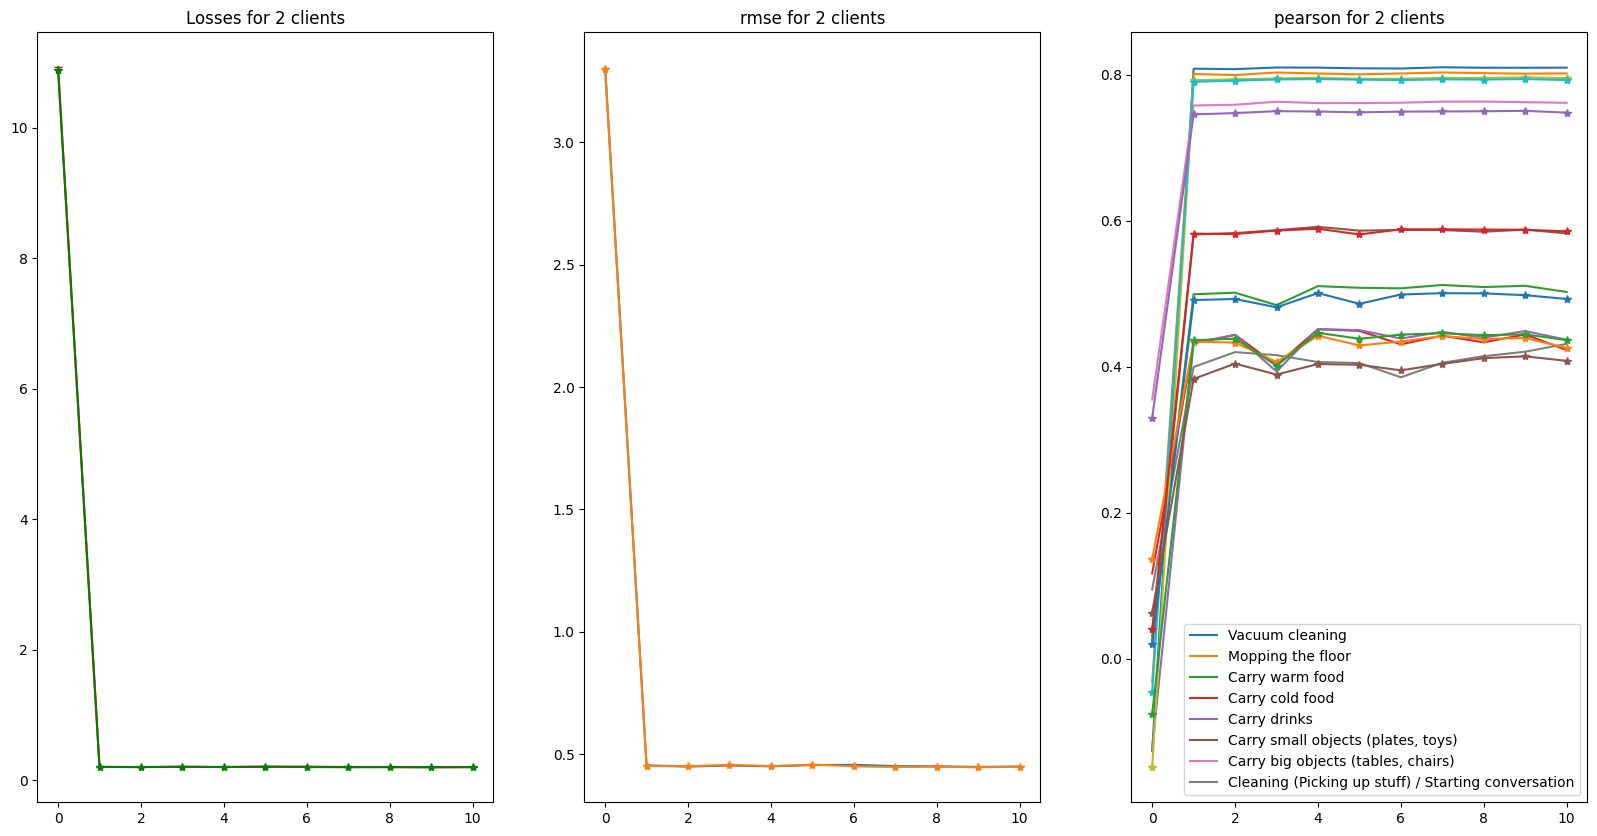

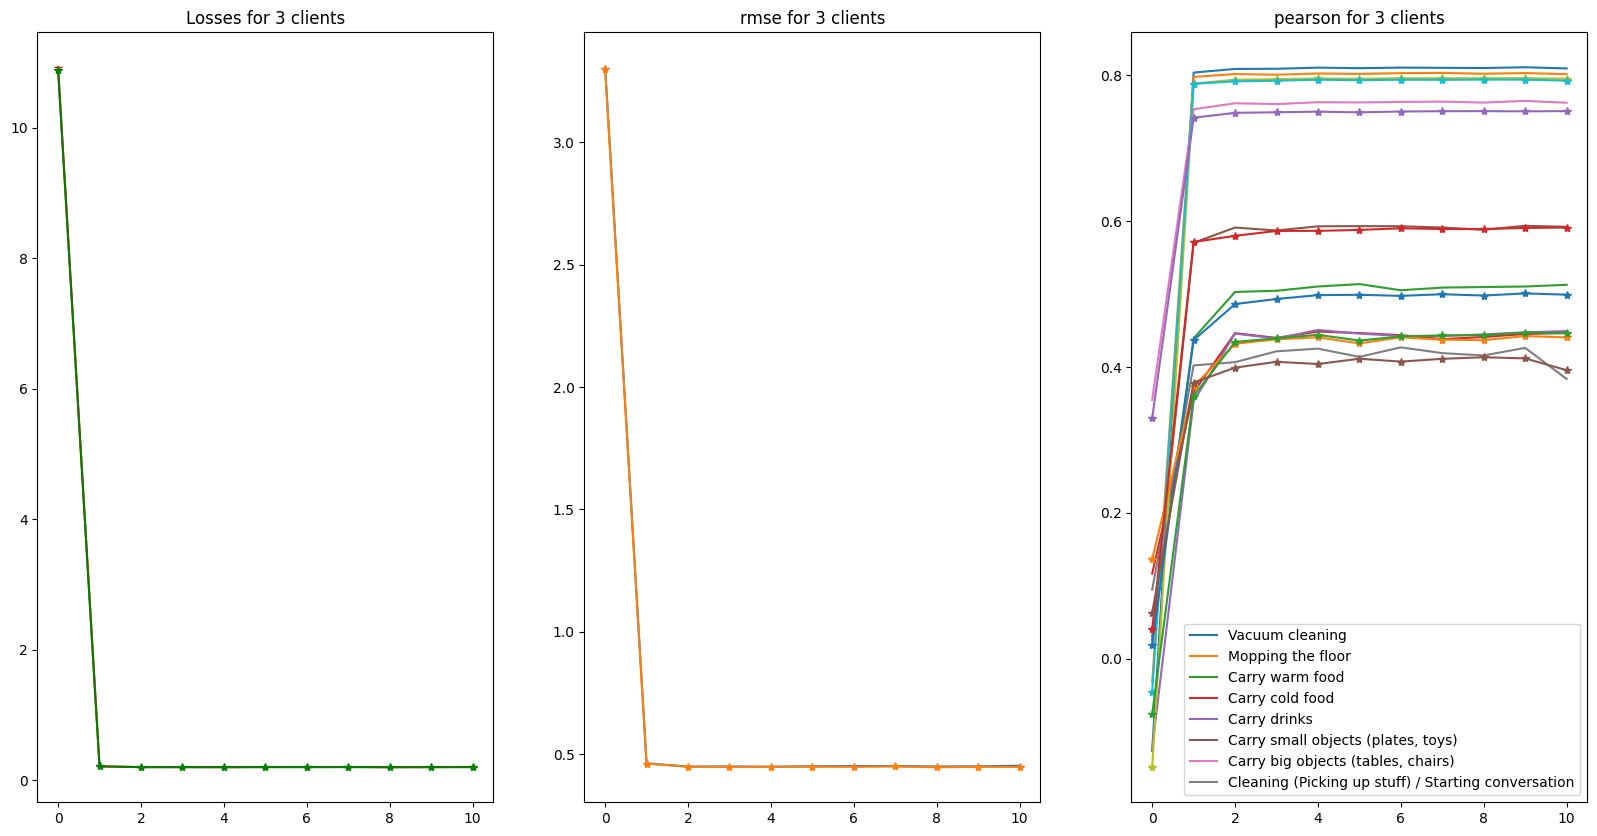

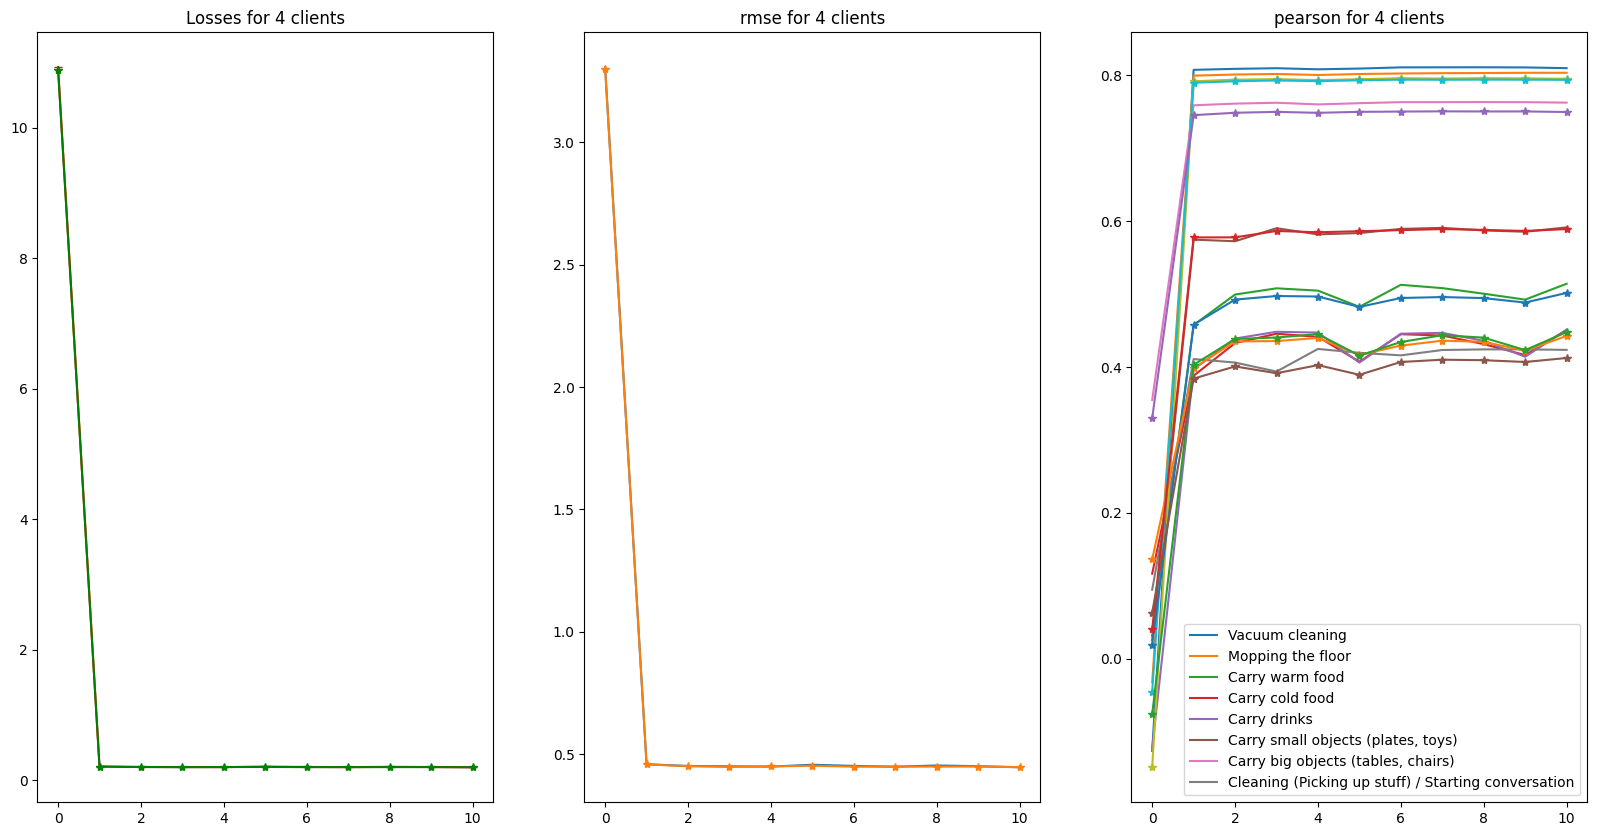

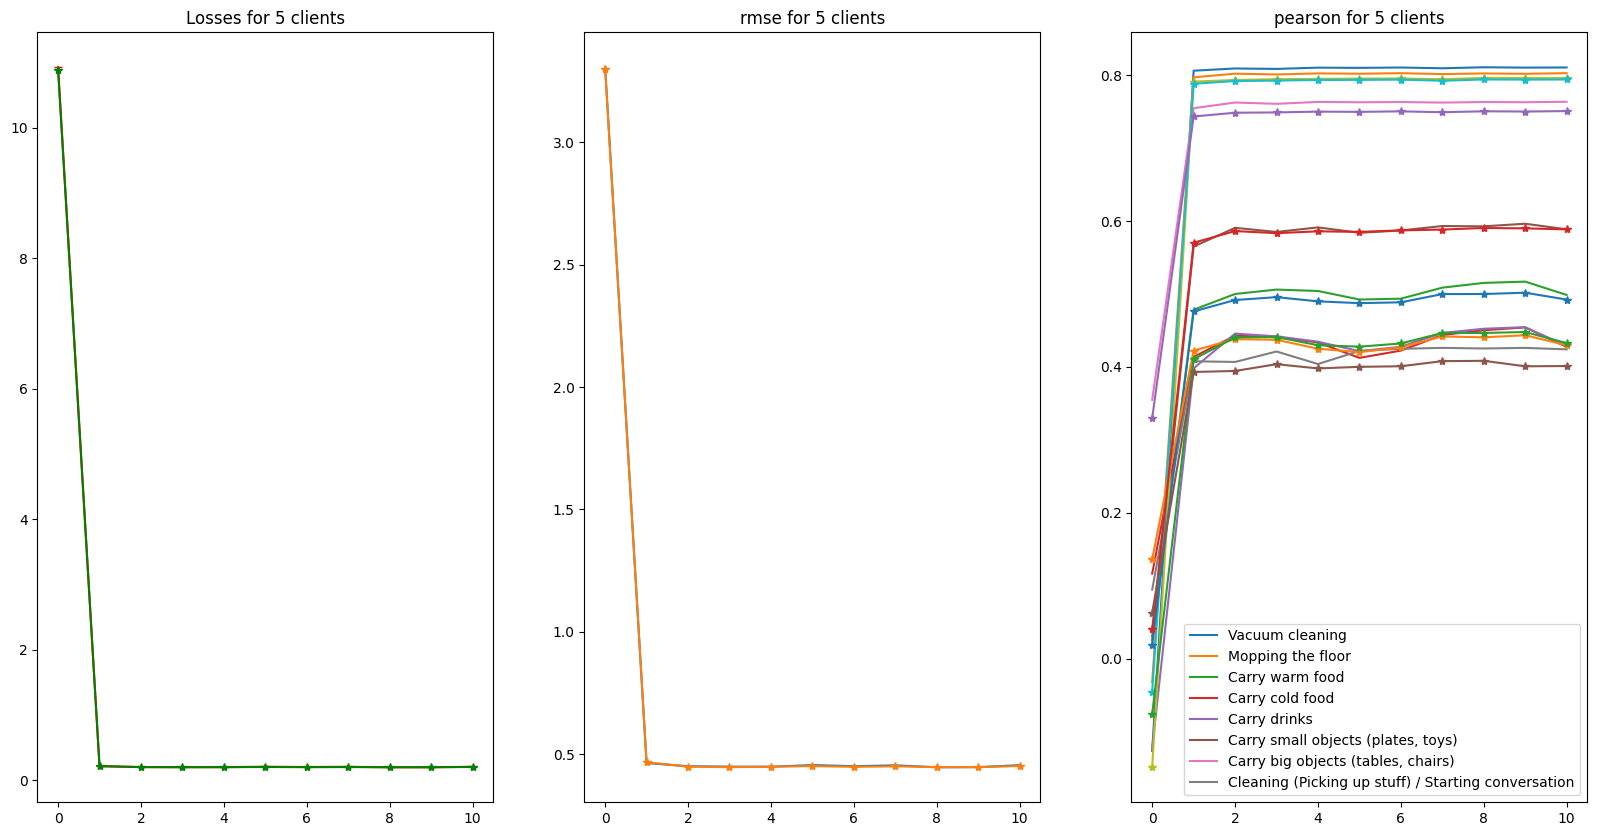

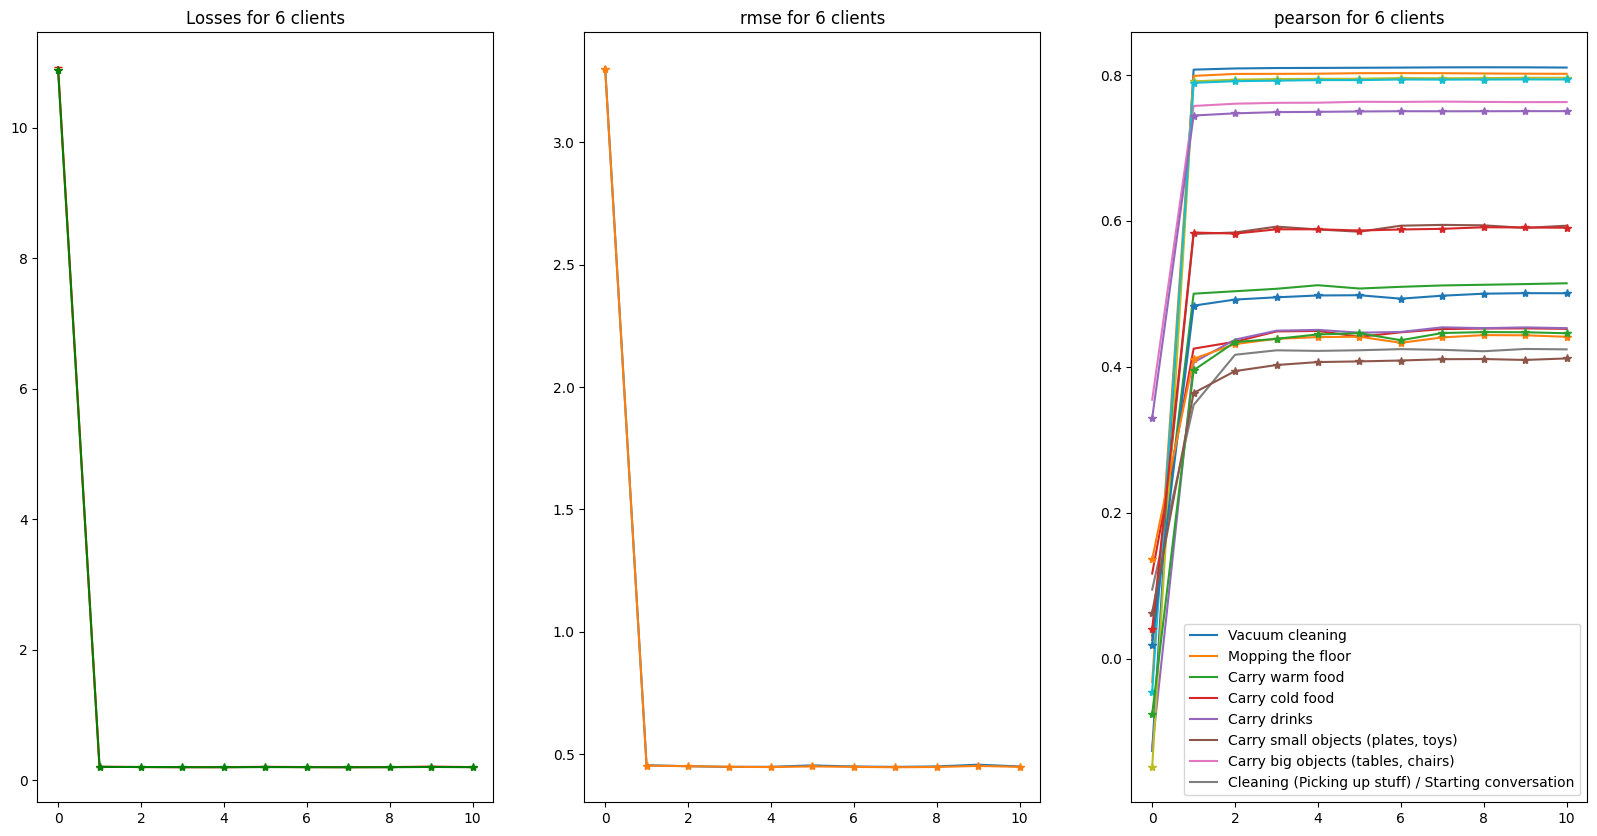

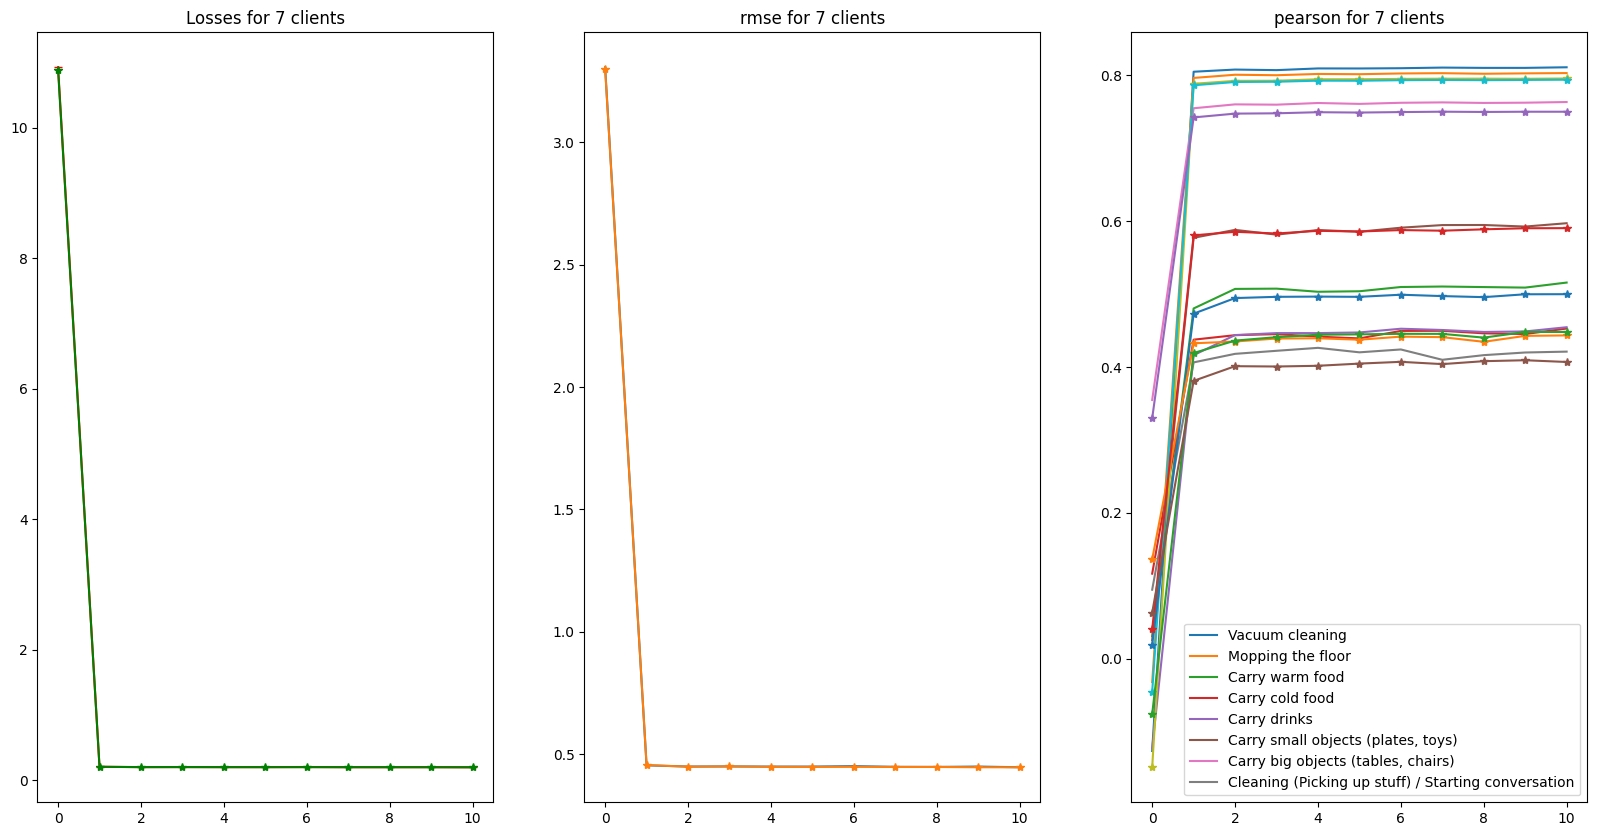

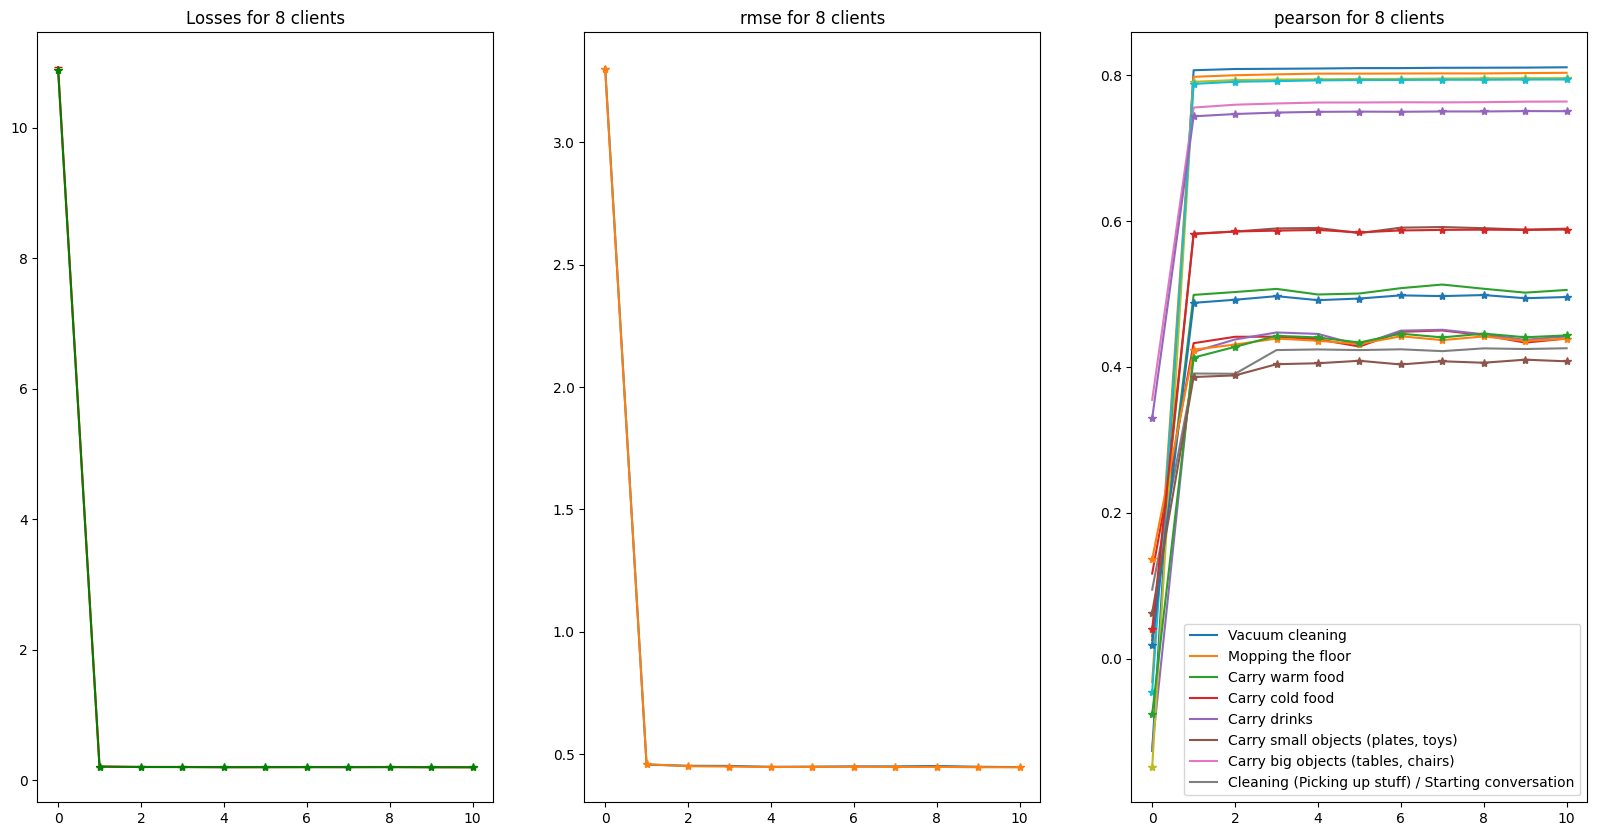

In [ ]:
#for each client, plot losses, rmse in separate graphs and pearson of each label in a single graph with all labels marked in the legend
import matplotlib.pyplot as plt
for i in range(len(results)):
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.plot(results[i]['Losses'], marker='_', color='red')
    plt.title("Losses for "+str(results[i]['clients'])+" clients")
    # plt.figure(figsize=(10,5))
    plt.plot(results_train[i]['Losses'],marker='*', color='green')
    plt.subplot(1,3,2)
    plt.plot(results[i]['rmse'])
    plt.plot(results_train[i]['rmse'], marker='*')

    plt.title("rmse for "+str(results[i]['clients'])+" clients")
    plt.subplot(1,3,3)
    for j in range(len(y_labels)):
        plt.plot(results[i]['pearson'][y_labels[j]])
    for j in range(len(y_labels)):
        plt.plot(results_train[i]['pearson'][y_labels[j]],marker='*')
    plt.title("pearson for "+str(results[i]['clients'])+" clients")
    plt.legend(y_labels)
    plt.savefig(f"{path}/{i+2}/{strat}.png")


In [ ]:
import json
for i in range(len(results)):
    with open(f"{path}/{i+2}/{strat}/"+str(results[i]['clients'])+"clients.json", "w") as outfile:
        json.dump(results[i], outfile)


In [ ]:
#load the results from the path "/results/fedAvgN" and create a dataframe with losses, rmse and average pearson of every label for each client
import json
import os
results=[]
for i in range(2,11):
    with open(f"{path}/{i}/{strat}/"+str(i)+"clients.json") as json_file:
        results.append(json.load(json_file))
import pandas as pd
df=pd.DataFrame(results)
df.head()

In [ ]:
df=pd.DataFrame(results)


In [ ]:
#add a new column named pearson_avg
df['pearson_avg']=[[] for i in range(len(df))]


In [ ]:
df.head()

In [ ]:
y_labels=list(df['pearson'][0].keys())

for i in range(df.shape[0]):
    li=[]
    for k in range(10):
        sum=0
        for j in range(len(y_labels)):
            sum=sum+df['pearson'][i][y_labels[j]][k]
        sum=sum/10
        li.append(sum)
    df['pearson_avg'][i]=li



In [ ]:
for i in range(df.shape[0]):
  # mini=min(df['Losses'][i])
  # idx=df['Losses'][i].index(mini)
  # print(idx)
  idx=-1
  df['Losses'][i]=df['Losses'][i][idx]
  df['rmse'][i]=df['rmse'][i][idx]
  df['pearson_avg'][i]=df['pearson_avg'][i][idx]


In [ ]:
df

In [ ]:
df.drop(['pearson'], axis=1, inplace=True)

In [ ]:
for i in range(df.shape[0]):
  try:
    data=pd.read_csv(f"{path}/clients{i+2}.csv")
    data.drop(["Unnamed: 0"], axis=1, inplace=True)
  except:
    data=pd.DataFrame(columns=["methods", "Loss", "RMSE", "PCC"])
  # data=data.append(pd.Series(["FedAvg_NoAug",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]]), ignore_index=True)
  data=pd.concat([data,pd.Series([f"{strat}",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]] , index=data.columns ).to_frame().T])
  data.to_csv(f"{path}/clients{i+2}.csv")

